[View in Colaboratory](https://colab.research.google.com/github/opooladz/ece_210_final_project/blob/master/LSTM/210_final_project_LSTM.ipynb)

In [2]:
# Import Libs 
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math
import tensorflow as tf
import keras

%matplotlib inline

Using TensorFlow backend.


In [0]:
from keras import backend as K

def categorical_crossentropy_with_masking(yTrue,yPred):
  """
  Custom loss function to allow for masking 
  Assumption is that yTrue has a one-hot encoding and only has an all zero vector if that element should be masked
  """
  #find which values in yTrue (target) are 0
  #since y is shaped as (batch, length, features), the entire output vector must be true
  mask = K.all(K.equal(yTrue, 0), axis=-1)
  mask = 1 - K.cast(mask, K.floatx())
  # multiply categorical_crossentropy with the mask
  loss = K.categorical_crossentropy(yTrue, yPred) * mask

  # take average w.r.t. the number of unmasked entries
  return K.sum(loss) / K.sum(mask)

def accuracy_with_masking(yTrue,yPred):
  """
  Custom metric function to allow for masking
  """
  mask = K.all(K.equal(yTrue, 0), axis=-1)
  mask = 1 - K.cast(mask, K.floatx())
  # Get categorical accuracy
  loss = K.cast(K.equal(K.argmax(yTrue, axis=-1),
                          K.argmax(yPred, axis=-1)),
                  K.floatx()) 
  loss = loss*mask

  # take average w.r.t. the number of unmasked entries
  return K.sum(loss) / K.sum(mask)

# Keras try model 
def try_model_lstm(model, data, epochs=200, verbose=1):
  """
  model - Keras model
  data - dictionary of training, testing, and validation data 
  name - str, name to save file under
  epochs - number of epochs to run
  verbose- boolean
  mask - array to mask output
  """
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy_with_masking', factor=0.2,
                              patience=5,verbose = verbose)
  model.compile(optimizer='nadam',
            loss=categorical_crossentropy_with_masking,
            metrics=[accuracy_with_masking])

  model.summary()  
  history = model.fit(data['x_train'], data['y_train'], 
            epochs=epochs, batch_size=250, verbose=verbose, 
            validation_data=(data['x_val'], data['y_val']),
                     callbacks=[reduce_lr])  
  score = model.evaluate(data['x_test'], data['y_test'])
  print('Test accuracy: {}'.format(score))
  
  return history,score

def try_model_conv(model, data, epochs=200, verbose=1):
  """
  model - Keras model
  data - dictionary of training, testing, and validation data 
  name - str, name to save file under
  epochs - number of epochs to run
  verbose- boolean
  mask - array to mask output
  """
  model.compile(optimizer='nadam',
            loss="categorical_crossentropy",
            metrics=["accuracy"])

  model.summary()  
  history = model.fit(data['x_train'], data['y_train'], 
            epochs=epochs, batch_size=250, verbose=verbose, 
            validation_data=(data['x_val'], data['y_val']))  
  score = model.evaluate(data['x_test'], data['y_test'])
  print('Test accuracy: {}'.format(score))
  
  return history,score

# Time-Invariant Channel

In [0]:
# Comms Stuff Will add more later
def qammod(m,y):
  if(np.all(y>=m)):
    print('qammod: all elements of X must be in range [0,M-1]')
  
  if (~np.all(y == np.fix(y) ) ):
    print("qammod: all elements of X must be integers");
  
  c = np.sqrt(m);
  if( ~(np.all(c == np.fix(c)) and np.all(np.math.log(c, 2) == np.fix(np.math.log(c, 2))) ) ):
    print("qammod: M must be a square of a power of 2");
  
  b = -2*np.fmod(y,c) + c - 1.;
  a = 2*np.floor(y *1./c) - c + 1.;
  x = a + 1.*1j*b
  # lets hold x in a np array([real,imag])
  # x = np.array([a,1.*b]).T
  return [x , y] 

def qammod2(m,size,trials):
  """
  m - highest integer for the randint
  """
  y = np.random.randint(m,size=(trials,size))
  if(np.all(y>=m)):
    print('qammod: all elements of X must be in range [0,M-1]')
  
  if (~np.all(y == np.fix(y) ) ):
    print("qammod: all elements of X must be integers");
  
  c = np.sqrt(m);
  if( ~(np.all(c == np.fix(c)) and np.all(np.math.log(c, 2) == np.fix(np.math.log(c, 2))) ) ):
    print("qammod: M must be a square of a power of 2");
  
  b = -2*np.fmod(y,c) + c - 1.;
  a = 2*np.floor(y *1./c) - c + 1.;
  #x = a + 1.*1j*b
  # lets hold x in a dp array([real,imag])
  #x = np.array([a,1.*b])
  x = np.dstack((a,b))
  return [x , y]                        

def sim_channel(m,sequenceLen,trials,Noise,SNRdB,h):
  """
  Simulates a channel
  Input:
    m - order of modulation
    sequenceLen - lenght of sequence
    trials - number trials
    Noise - Boolean, if noise should be added
    SNRdB - Ratio of signal to noise
    h- channel parameters
  """
  [x,y] = qammod2(m,sequenceLen,trials)
  
  xh = np.apply_along_axis(lambda q: np.convolve(q,h,mode="full"),axis = 1,arr=x)
  if(Noise):
    SNR = 10**(SNRdB/10)
    sym_noise_pow = np.var(xh)/SNR
    sym_noise_scale_fact = np.sqrt(sym_noise_pow/2)
    AWGN = sym_noise_scale_fact*np.random.normal(1, size=xh.shape) 
    xh = xh + AWGN
  return [xh ,y ]
  
  
def generateData(m,sequenceLen,trials,Noise,SNRdB,h,padding= True):
  """
  Generates training, testing, and validation data for time invariant channels
  Does one-hot encoding and padding
  m - symbol alphabet
  sequenceLen - length of data sequence
  trials - number of samples
  Noise- Boolean of whether to use AWGN
  SNRdB - amount of noise
  h - channel parameters
  """
  data={}
  [data['x_train'],data['y_train']] = sim_channel(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB,h=h)
  [data['x_val'],data['y_val']] = sim_channel(m=m,sequenceLen=sequenceLen,trials=int(trials*0.25),Noise= Noise,SNRdB=SNRdB,h=h)
  [data['x_test'],data['y_test']] = sim_channel(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB,h=h)
  
  print("x_train shape: ",data['x_train'].shape) # data, expected seqlen+chanelLen-1
  print("y_train shape: ",data['y_train'].shape) # labels
  
  #One hot encoding
  y_train = keras.utils.to_categorical(data['y_train'] , num_classes=m)
  y_val = keras.utils.to_categorical(data['y_val'] , num_classes=m)
  y_test = keras.utils.to_categorical(data['y_test'] , num_classes=m)
  print("y_train shape, one-hot: ",y_train.shape)

  #Padding 
  if(padding):
    y_train = np.pad(y_train,((0,0),(0,chanelLen-1),(0,0)),"constant")
    y_val = np.pad(y_val,((0,0),(0,chanelLen-1),(0,0)),"constant")
    y_test = np.pad(y_test,((0,0),(0,chanelLen-1),(0,0)),"constant")

  print("y_train shape, one-hot, padding: ",y_train.shape)

  default_data = {
    'x_train': data['x_train'],
    'x_val': data['x_val'],
    'x_test': data['x_test'],
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
  }
  return default_data
  

In [6]:
# Instantiating Data

m = 4         # order of modulation
trials = 10000 # number of trials 
Noise = True
SNRdB = 10
seqLen = 300
print(seqLen)
#h = [1,0.4,0.3,0.2,0.25]
chanelLen = 5
h = np.random.rand(chanelLen)
h[0] = 1

300


In [151]:
# QAM-4
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense,CuDNNLSTM, TimeDistributed,Softmax,Flatten,Bidirectional,Reshape,Embedding,Conv1D, Softmax,Flatten,BatchNormalization
import keras

#LSTM
default_data_pad = generateData(m,seqLen,trials,Noise,SNRdB,h,padding=True)
modLSTM = Sequential()
#modLSTM.add(Bidirectional(CuDNNLSTM(10,return_sequences=True),input_shape=(seqLen+chanelLen-1,2)))
modLSTM.add(CuDNNLSTM(30,return_sequences=True,input_shape=(seqLen+chanelLen-1,2)))
modLSTM.add(TimeDistributed(Dense(m,activation="softmax")))
hist,score = try_model_lstm(modLSTM, default_data_pad, epochs=5)
print(score)
print(hist.history)

#CNN
default_data_no_pad = generateData(m,seqLen,trials,Noise,SNRdB,h,padding=False)
modCNN = Sequential()
modCNN.add(Conv1D(5,kernel_size=(chanelLen+1), input_shape=(seqLen+chanelLen-1,2) ))
# modCNN.add(BatchNormalization())
# modCNN.add(Flatten())
# modCNN.add(Dense(seqLen*m,bias_regularizer=regularizers.l2(0.005)))
modCNN.add(Reshape(target_shape = (seqLen,m)))
modCNN.add(TimeDistributed(Dense(m,activation="softmax")))
modCNN.add(Softmax(axis=2))
hist,score = try_model_conv(modCNN, default_data_no_pad, epochs=10)
print(score)
print(hist.history)

x_train shape:  (10000, 304, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 304, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_46 (CuDNNLSTM)    (None, 304, 30)           4080      
_________________________________________________________________
time_distributed_83 (TimeDis (None, 304, 4)            124       
Total params: 4,204
Trainable params: 4,204
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/5
 4864/10000 [=============>................] - ETA: 9s - loss: 1.0472 - accuracy_with_masking: 0.6179

KeyboardInterrupt: ignored

## Comparing Equalizer symbol error across different SNR

In [41]:
m = 4         # order of modulation
trials = 10000   # number of trials 
Noise = True
x = 4
seqLen = 300
print(seqLen)
# chanelLen = 5
# h = np.random.rand(chanelLen)*0.5
# h[0] = 1
h = np.array([1,0.5,-0.3])
chanelLen = len(h)
print("Channel: ",h)

snrs = np.linspace(10,-15,10)
histories_lstm = []
scores_lstm = []
histories_conv = []
scores_conv = []
for SNRdB in snrs:
  print("SNRdB: ",SNRdB)

  #LSTM
  default_data_pad = generateData(m,seqLen,trials,Noise,SNRdB,h,padding=True)
  modLSTM = Sequential()
  modLSTM.add(CuDNNLSTM(30,return_sequences=True,input_shape=(seqLen+chanelLen-1,2)))
  modLSTM.add(TimeDistributed(Dense(m,activation="softmax")))
  hist,score = try_model_lstm(modLSTM, default_data_pad, epochs=5)
  print(score)
  histories_lstm.append(hist)
  scores_lstm.append(score)
  
  #CNN
  default_data_no_pad = generateData(m,seqLen,trials,Noise,SNRdB,h,padding=False)
  modCNN = Sequential()
  modCNN.add(Conv1D(10,kernel_size=(chanelLen), input_shape=(seqLen+chanelLen-1,2) ))
  modCNN.add(BatchNormalization())
  modCNN.add(Flatten())
  modCNN.add(Dense(seqLen*m,bias_regularizer=regularizers.l2(0.005)))
  modCNN.add(Reshape(target_shape = (seqLen,m)))
  modCNN.add(Softmax(axis=2))
  hist,score = try_model_conv(modCNN, default_data_no_pad, epochs=10)
  print(score)
  histories_conv.append(hist)
  scores_conv.append(score)
  print("Score: ",score)

300
Channel:  [ 1.   0.5 -0.3]
SNRdB:  10.0
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_11 (CuDNNLSTM)    (None, 302, 30)           4080      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 302, 4)            124       
Total params: 4,204
Trainable params: 4,204
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/5
10000/10000 [==============================] - 9s 911us/step - loss: 0.8814 - accuracy_with_masking: 0.7747 - val_loss: 0.3773 - val_accuracy_with_masking: 0.9906
Epoch 2/5
 1408/10000 [===>..........................] - ETA: 5s - loss: 0.3415 - accuracy_with_masking: 0.9922

10000/10000 [==============================] - 8s 753us/step - loss: 0.2087 - accuracy_with_masking: 0.9956 - val_loss: 0.1112 - val_accuracy_with_masking: 0.9974
Epoch 3/5
10000/10000 [==============================] - 7s 747us/step - loss: 0.0764 - accuracy_with_masking: 0.9980 - val_loss: 0.0524 - val_accuracy_with_masking: 0.9985
Epoch 4/5
10000/10000 [==============================] - 7s 733us/step - loss: 0.0401 - accuracy_with_masking: 0.9987 - val_loss: 0.0307 - val_accuracy_with_masking: 0.9990
Epoch 5/5
 6848/10000 [===================>..........] - ETA: 2s - loss: 0.0265 - accuracy_with_masking: 0.9991

10000/10000 [==============================] - 6s 631us/step
Test accuracy: [0.02040519337952137, 0.9992136647224427]
[0.02040519337952137, 0.9992136647224427]
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_12 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_12 (Flatten)         (None, 3000)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_12 (Reshape)        

10000/10000 [==============================] - 4s 409us/step - loss: 0.9330 - acc: 0.6370 - val_loss: 0.4463 - val_acc: 0.8975
Epoch 2/10
10000/10000 [==============================] - 3s 257us/step - loss: 0.2657 - acc: 0.9567 - val_loss: 0.1822 - val_acc: 0.9766
Epoch 3/10
10000/10000 [==============================] - 3s 253us/step - loss: 0.1191 - acc: 0.9885 - val_loss: 0.1032 - val_acc: 0.9869
Epoch 4/10
10000/10000 [==============================] - 3s 254us/step - loss: 0.0698 - acc: 0.9944 - val_loss: 0.0720 - val_acc: 0.9894
Epoch 5/10
10000/10000 [==============================] - 3s 254us/step - loss: 0.0468 - acc: 0.9968 - val_loss: 0.0567 - val_acc: 0.9902
Epoch 6/10
 8064/10000 [=======================>......] - ETA: 0s - loss: 0.0336 - acc: 0.9983

10000/10000 [==============================] - 3s 257us/step - loss: 0.0339 - acc: 0.9980 - val_loss: 0.0480 - val_acc: 0.9905
Epoch 7/10
10000/10000 [==============================] - 2s 246us/step - loss: 0.0256 - acc: 0.9988 - val_loss: 0.0423 - val_acc: 0.9908
Epoch 8/10
10000/10000 [==============================] - 3s 254us/step - loss: 0.0201 - acc: 0.9992 - val_loss: 0.0385 - val_acc: 0.9907
Epoch 9/10
10000/10000 [==============================] - 3s 252us/step - loss: 0.0159 - acc: 0.9995 - val_loss: 0.0361 - val_acc: 0.9906
Epoch 10/10
10000/10000 [==============================] - 1s 125us/step
Test accuracy: [0.03367891373038292, 0.9907936644554138]
[0.03367891373038292, 0.9907936644554138]
Score:  [0.03367891373038292, 0.9907936644554138]
SNRdB:  7.222222222222222
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
___________________________________________________________

10000/10000 [==============================] - 9s 922us/step - loss: 0.9352 - accuracy_with_masking: 0.7355 - val_loss: 0.4762 - val_accuracy_with_masking: 0.9635
Epoch 2/5
10000/10000 [==============================] - 7s 741us/step - loss: 0.2913 - accuracy_with_masking: 0.9741 - val_loss: 0.1743 - val_accuracy_with_masking: 0.9799
Epoch 3/5
10000/10000 [==============================] - 7s 731us/step - loss: 0.1252 - accuracy_with_masking: 0.9837 - val_loss: 0.0901 - val_accuracy_with_masking: 0.9867
Epoch 4/5
 6400/10000 [==================>...........] - ETA: 2s - loss: 0.0779 - accuracy_with_masking: 0.9878

10000/10000 [==============================] - 7s 743us/step - loss: 0.0726 - accuracy_with_masking: 0.9883 - val_loss: 0.0593 - val_accuracy_with_masking: 0.9896
Epoch 5/5
10000/10000 [==============================] - 6s 619us/step
Test accuracy: [0.045618675780296325, 0.9904913307189941]
[0.045618675780296325, 0.9904913307189941]
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_13 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_13 (Flatten)         (None, 3000)              0         
___________________________________________________

10000/10000 [==============================] - 4s 423us/step - loss: 0.9549 - acc: 0.6218 - val_loss: 0.4858 - val_acc: 0.8688
Epoch 2/10
10000/10000 [==============================] - 3s 260us/step - loss: 0.3143 - acc: 0.9274 - val_loss: 0.2401 - val_acc: 0.9436
Epoch 3/10
10000/10000 [==============================] - 3s 259us/step - loss: 0.1750 - acc: 0.9618 - val_loss: 0.1662 - val_acc: 0.9552
Epoch 4/10
10000/10000 [==============================] - 3s 258us/step - loss: 0.1240 - acc: 0.9707 - val_loss: 0.1378 - val_acc: 0.9573
Epoch 5/10
10000/10000 [==============================] - 3s 257us/step - loss: 0.0987 - acc: 0.9746 - val_loss: 0.1260 - val_acc: 0.9574
Epoch 6/10
 7040/10000 [====================>.........] - ETA: 0s - loss: 0.0803 - acc: 0.9794

10000/10000 [==============================] - 3s 259us/step - loss: 0.0842 - acc: 0.9768 - val_loss: 0.1217 - val_acc: 0.9562
Epoch 7/10
10000/10000 [==============================] - 3s 256us/step - loss: 0.0744 - acc: 0.9782 - val_loss: 0.1206 - val_acc: 0.9552
Epoch 8/10
10000/10000 [==============================] - 3s 259us/step - loss: 0.0675 - acc: 0.9794 - val_loss: 0.1221 - val_acc: 0.9542
Epoch 9/10
10000/10000 [==============================] - 3s 259us/step - loss: 0.0625 - acc: 0.9801 - val_loss: 0.1247 - val_acc: 0.9532
Epoch 10/10
10000/10000 [==============================] - 1s 124us/step
Test accuracy: [0.1281036313533783, 0.9525976661682128]
[0.1281036313533783, 0.9525976661682128]
Score:  [0.1281036313533783, 0.9525976661682128]
SNRdB:  4.444444444444445
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
______________________________________________________________

10000/10000 [==============================] - 9s 943us/step - loss: 1.0403 - accuracy_with_masking: 0.6694 - val_loss: 0.6353 - val_accuracy_with_masking: 0.8918
Epoch 2/5
10000/10000 [==============================] - 7s 743us/step - loss: 0.4473 - accuracy_with_masking: 0.9071 - val_loss: 0.3339 - val_accuracy_with_masking: 0.9153
Epoch 3/5
10000/10000 [==============================] - 7s 727us/step - loss: 0.2836 - accuracy_with_masking: 0.9215 - val_loss: 0.2429 - val_accuracy_with_masking: 0.9279
Epoch 4/5
 6592/10000 [==================>...........] - ETA: 2s - loss: 0.2268 - accuracy_with_masking: 0.9307

10000/10000 [==============================] - 7s 726us/step - loss: 0.2205 - accuracy_with_masking: 0.9317 - val_loss: 0.2015 - val_accuracy_with_masking: 0.9350
Epoch 5/5
10000/10000 [==============================] - 6s 622us/step
Test accuracy: [0.18353578412532806, 0.9377880000114441]
[0.18353578412532806, 0.9377880000114441]
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_14 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_14 (Flatten)         (None, 3000)              0         
_____________________________________________________

10000/10000 [==============================] - 4s 446us/step - loss: 1.0047 - acc: 0.5875 - val_loss: 0.5779 - val_acc: 0.8041
Epoch 2/10
10000/10000 [==============================] - 3s 261us/step - loss: 0.4180 - acc: 0.8656 - val_loss: 0.3564 - val_acc: 0.8790
Epoch 3/10
10000/10000 [==============================] - 3s 260us/step - loss: 0.2868 - acc: 0.9041 - val_loss: 0.2933 - val_acc: 0.8915
Epoch 4/10
10000/10000 [==============================] - 3s 259us/step - loss: 0.2406 - acc: 0.9145 - val_loss: 0.2746 - val_acc: 0.8943
Epoch 5/10
10000/10000 [==============================] - 3s 259us/step - loss: 0.2184 - acc: 0.9196 - val_loss: 0.2708 - val_acc: 0.8949
Epoch 6/10
 7680/10000 [======================>.......] - ETA: 0s - loss: 0.1976 - acc: 0.9269

10000/10000 [==============================] - 3s 256us/step - loss: 0.2054 - acc: 0.9231 - val_loss: 0.2728 - val_acc: 0.8953
Epoch 7/10
10000/10000 [==============================] - 3s 257us/step - loss: 0.1960 - acc: 0.9262 - val_loss: 0.2771 - val_acc: 0.8950
Epoch 8/10
10000/10000 [==============================] - 3s 261us/step - loss: 0.1881 - acc: 0.9290 - val_loss: 0.2813 - val_acc: 0.8952
Epoch 9/10
10000/10000 [==============================] - 3s 254us/step - loss: 0.1817 - acc: 0.9313 - val_loss: 0.2869 - val_acc: 0.8952
Epoch 10/10
10000/10000 [==============================] - 1s 126us/step
Test accuracy: [0.2903174907684326, 0.8954090016365052]
[0.2903174907684326, 0.8954090016365052]
Score:  [0.2903174907684326, 0.8954090016365052]
SNRdB:  1.6666666666666679
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_____________________________________________________________

10000/10000 [==============================] - 9s 932us/step - loss: 1.0064 - accuracy_with_masking: 0.6458 - val_loss: 0.6642 - val_accuracy_with_masking: 0.7967
Epoch 2/5
10000/10000 [==============================] - 7s 731us/step - loss: 0.5553 - accuracy_with_masking: 0.8073 - val_loss: 0.4954 - val_accuracy_with_masking: 0.8139
Epoch 3/5
10000/10000 [==============================] - 7s 744us/step - loss: 0.4753 - accuracy_with_masking: 0.8179 - val_loss: 0.4622 - val_accuracy_with_masking: 0.8219
Epoch 4/5
 6400/10000 [==================>...........] - ETA: 2s - loss: 0.4582 - accuracy_with_masking: 0.8229

10000/10000 [==============================] - 7s 738us/step - loss: 0.4562 - accuracy_with_masking: 0.8237 - val_loss: 0.4526 - val_accuracy_with_masking: 0.8254
Epoch 5/5
10000/10000 [==============================] - 6s 630us/step
Test accuracy: [0.4474921380996704, 0.8268539992332459]
[0.4474921380996704, 0.8268539992332459]
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_15 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_15 (Flatten)         (None, 3000)              0         
_______________________________________________________

10000/10000 [==============================] - 5s 460us/step - loss: 1.0657 - acc: 0.5508 - val_loss: 0.6818 - val_acc: 0.7374
Epoch 2/10
10000/10000 [==============================] - 3s 265us/step - loss: 0.5564 - acc: 0.7891 - val_loss: 0.5290 - val_acc: 0.7894
Epoch 3/10
10000/10000 [==============================] - 3s 263us/step - loss: 0.4670 - acc: 0.8174 - val_loss: 0.4979 - val_acc: 0.7996
Epoch 4/10
10000/10000 [==============================] - 3s 262us/step - loss: 0.4373 - acc: 0.8276 - val_loss: 0.4918 - val_acc: 0.8038
Epoch 5/10
10000/10000 [==============================] - 3s 258us/step - loss: 0.4219 - acc: 0.8341 - val_loss: 0.4911 - val_acc: 0.8061
Epoch 6/10
 6656/10000 [==================>...........] - ETA: 0s - loss: 0.3920 - acc: 0.8471

10000/10000 [==============================] - 3s 264us/step - loss: 0.4092 - acc: 0.8397 - val_loss: 0.4903 - val_acc: 0.8081
Epoch 7/10
10000/10000 [==============================] - 3s 260us/step - loss: 0.3981 - acc: 0.8443 - val_loss: 0.4888 - val_acc: 0.8097
Epoch 8/10
10000/10000 [==============================] - 3s 261us/step - loss: 0.3889 - acc: 0.8479 - val_loss: 0.4873 - val_acc: 0.8111
Epoch 9/10
10000/10000 [==============================] - 3s 258us/step - loss: 0.3806 - acc: 0.8518 - val_loss: 0.4858 - val_acc: 0.8112
Epoch 10/10
10000/10000 [==============================] - 1s 126us/step
Test accuracy: [0.48443298344612123, 0.8128626669883728]
[0.48443298344612123, 0.8128626669883728]
Score:  [0.48443298344612123, 0.8128626669883728]
SNRdB:  -1.1111111111111107
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________

10000/10000 [==============================] - 10s 1ms/step - loss: 1.0686 - accuracy_with_masking: 0.6092 - val_loss: 0.8204 - val_accuracy_with_masking: 0.6890
Epoch 2/5
10000/10000 [==============================] - 7s 746us/step - loss: 0.7686 - accuracy_with_masking: 0.6923 - val_loss: 0.7464 - val_accuracy_with_masking: 0.6944
Epoch 3/5
10000/10000 [==============================] - 7s 744us/step - loss: 0.7438 - accuracy_with_masking: 0.6955 - val_loss: 0.7401 - val_accuracy_with_masking: 0.6968
Epoch 4/5
 6272/10000 [=================>............] - ETA: 2s - loss: 0.7406 - accuracy_with_masking: 0.6967

10000/10000 [==============================] - 7s 740us/step - loss: 0.7397 - accuracy_with_masking: 0.6972 - val_loss: 0.7372 - val_accuracy_with_masking: 0.6980
Epoch 5/5
10000/10000 [==============================] - 6s 629us/step
Test accuracy: [0.7373781826019287, 0.6978483331680297]
[0.7373781826019287, 0.6978483331680297]
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_16 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_16 (Flatten)         (None, 3000)              0         
_______________________________________________________

10000/10000 [==============================] - 5s 465us/step - loss: 1.1691 - acc: 0.4915 - val_loss: 0.8717 - val_acc: 0.6322
Epoch 2/10
10000/10000 [==============================] - 3s 261us/step - loss: 0.7628 - acc: 0.6857 - val_loss: 0.7640 - val_acc: 0.6805
Epoch 3/10
10000/10000 [==============================] - 3s 254us/step - loss: 0.6986 - acc: 0.7140 - val_loss: 0.7459 - val_acc: 0.6920
Epoch 4/10
10000/10000 [==============================] - 3s 259us/step - loss: 0.6750 - acc: 0.7250 - val_loss: 0.7384 - val_acc: 0.6977
Epoch 5/10
10000/10000 [==============================] - 3s 259us/step - loss: 0.6562 - acc: 0.7337 - val_loss: 0.7318 - val_acc: 0.7010
Epoch 6/10
 7872/10000 [======================>.......] - ETA: 0s - loss: 0.6323 - acc: 0.7446

10000/10000 [==============================] - 3s 250us/step - loss: 0.6422 - acc: 0.7399 - val_loss: 0.7268 - val_acc: 0.7030
Epoch 7/10
10000/10000 [==============================] - 3s 252us/step - loss: 0.6308 - acc: 0.7449 - val_loss: 0.7233 - val_acc: 0.7043
Epoch 8/10
10000/10000 [==============================] - 2s 250us/step - loss: 0.6228 - acc: 0.7483 - val_loss: 0.7208 - val_acc: 0.7055
Epoch 9/10
10000/10000 [==============================] - 2s 249us/step - loss: 0.6162 - acc: 0.7515 - val_loss: 0.7194 - val_acc: 0.7062
Epoch 10/10
10000/10000 [==============================] - 1s 128us/step
Test accuracy: [0.7186088981628418, 0.7067906662940979]
[0.7186088981628418, 0.7067906662940979]
Score:  [0.7186088981628418, 0.7067906662940979]
SNRdB:  -3.8888888888888893
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
____________________________________________________________

10000/10000 [==============================] - 10s 981us/step - loss: 1.1454 - accuracy_with_masking: 0.5191 - val_loss: 0.9786 - val_accuracy_with_masking: 0.5863
Epoch 2/5
10000/10000 [==============================] - 8s 754us/step - loss: 0.9698 - accuracy_with_masking: 0.5868 - val_loss: 0.9668 - val_accuracy_with_masking: 0.5878
Epoch 3/5
10000/10000 [==============================] - 7s 748us/step - loss: 0.9661 - accuracy_with_masking: 0.5875 - val_loss: 0.9651 - val_accuracy_with_masking: 0.5882
Epoch 4/5
 6464/10000 [==================>...........] - ETA: 2s - loss: 0.9652 - accuracy_with_masking: 0.5875

10000/10000 [==============================] - 7s 734us/step - loss: 0.9649 - accuracy_with_masking: 0.5877 - val_loss: 0.9643 - val_accuracy_with_masking: 0.5883
Epoch 5/5
10000/10000 [==============================] - 6s 633us/step
Test accuracy: [0.964293137550354, 0.5880323347091675]
[0.964293137550354, 0.5880323347091675]
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_17 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_17 (Flatten)         (None, 3000)              0         
_________________________________________________________

10000/10000 [==============================] - 5s 496us/step - loss: 1.2710 - acc: 0.4388 - val_loss: 1.0422 - val_acc: 0.5439
Epoch 2/10
10000/10000 [==============================] - 3s 269us/step - loss: 0.9633 - acc: 0.5895 - val_loss: 0.9912 - val_acc: 0.5754
Epoch 3/10
10000/10000 [==============================] - 3s 267us/step - loss: 0.9228 - acc: 0.6109 - val_loss: 0.9778 - val_acc: 0.5842
Epoch 4/10
10000/10000 [==============================] - 3s 267us/step - loss: 0.8987 - acc: 0.6225 - val_loss: 0.9674 - val_acc: 0.5884
Epoch 5/10
10000/10000 [==============================] - 3s 260us/step - loss: 0.8807 - acc: 0.6302 - val_loss: 0.9614 - val_acc: 0.5907
Epoch 6/10
 7104/10000 [====================>.........] - ETA: 0s - loss: 0.8531 - acc: 0.6445

10000/10000 [==============================] - 3s 257us/step - loss: 0.8676 - acc: 0.6367 - val_loss: 0.9568 - val_acc: 0.5924
Epoch 7/10
10000/10000 [==============================] - 3s 259us/step - loss: 0.8586 - acc: 0.6409 - val_loss: 0.9551 - val_acc: 0.5934
Epoch 8/10
10000/10000 [==============================] - 3s 260us/step - loss: 0.8517 - acc: 0.6444 - val_loss: 0.9538 - val_acc: 0.5938
Epoch 9/10
10000/10000 [==============================] - 3s 260us/step - loss: 0.8464 - acc: 0.6471 - val_loss: 0.9525 - val_acc: 0.5942
Epoch 10/10
10000/10000 [==============================] - 1s 129us/step
Test accuracy: [0.9510939137458801, 0.5953286670684814]
[0.9510939137458801, 0.5953286670684814]
Score:  [0.9510939137458801, 0.5953286670684814]
SNRdB:  -6.666666666666664
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_____________________________________________________________

10000/10000 [==============================] - 10s 990us/step - loss: 1.1867 - accuracy_with_masking: 0.4752 - val_loss: 1.1302 - val_accuracy_with_masking: 0.4982
Epoch 2/5
10000/10000 [==============================] - 8s 765us/step - loss: 1.1310 - accuracy_with_masking: 0.4985 - val_loss: 1.1284 - val_accuracy_with_masking: 0.4992
Epoch 3/5
10000/10000 [==============================] - 8s 752us/step - loss: 1.1299 - accuracy_with_masking: 0.4989 - val_loss: 1.1276 - val_accuracy_with_masking: 0.4995
Epoch 4/5
 6400/10000 [==================>...........] - ETA: 2s - loss: 1.1296 - accuracy_with_masking: 0.4988

10000/10000 [==============================] - 7s 749us/step - loss: 1.1293 - accuracy_with_masking: 0.4991 - val_loss: 1.1272 - val_accuracy_with_masking: 0.4996
Epoch 5/5
10000/10000 [==============================] - 6s 631us/step
Test accuracy: [1.127930369758606, 0.49940366625785826]
[1.127930369758606, 0.49940366625785826]
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_18 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_18 (Flatten)         (None, 3000)              0         
_______________________________________________________

10000/10000 [==============================] - 5s 502us/step - loss: 1.3754 - acc: 0.3861 - val_loss: 1.2067 - val_acc: 0.4609
Epoch 2/10
10000/10000 [==============================] - 3s 270us/step - loss: 1.1389 - acc: 0.5027 - val_loss: 1.1794 - val_acc: 0.4816
Epoch 3/10
10000/10000 [==============================] - 3s 261us/step - loss: 1.1046 - acc: 0.5204 - val_loss: 1.1648 - val_acc: 0.4879
Epoch 4/10
10000/10000 [==============================] - 3s 262us/step - loss: 1.0795 - acc: 0.5318 - val_loss: 1.1535 - val_acc: 0.4909
Epoch 5/10
10000/10000 [==============================] - 3s 260us/step - loss: 1.0611 - acc: 0.5403 - val_loss: 1.1467 - val_acc: 0.4927
Epoch 6/10
 6656/10000 [==================>...........] - ETA: 0s - loss: 1.0310 - acc: 0.5568

10000/10000 [==============================] - 3s 260us/step - loss: 1.0479 - acc: 0.5468 - val_loss: 1.1428 - val_acc: 0.4941
Epoch 7/10
10000/10000 [==============================] - 3s 263us/step - loss: 1.0387 - acc: 0.5520 - val_loss: 1.1408 - val_acc: 0.4953
Epoch 8/10
10000/10000 [==============================] - 3s 264us/step - loss: 1.0323 - acc: 0.5551 - val_loss: 1.1396 - val_acc: 0.4952
Epoch 9/10
10000/10000 [==============================] - 3s 261us/step - loss: 1.0274 - acc: 0.5581 - val_loss: 1.1392 - val_acc: 0.4957
Epoch 10/10
10000/10000 [==============================] - 1s 131us/step
Test accuracy: [1.1395581382751465, 0.4949363323688507]
[1.1395581382751465, 0.4949363323688507]
Score:  [1.1395581382751465, 0.4949363323688507]
SNRdB:  -9.444444444444443
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_____________________________________________________________

10000/10000 [==============================] - 10s 999us/step - loss: 1.2865 - accuracy_with_masking: 0.3941 - val_loss: 1.2375 - val_accuracy_with_masking: 0.4314
Epoch 2/5
10000/10000 [==============================] - 7s 738us/step - loss: 1.2385 - accuracy_with_masking: 0.4300 - val_loss: 1.2365 - val_accuracy_with_masking: 0.4317
Epoch 3/5
10000/10000 [==============================] - 7s 731us/step - loss: 1.2379 - accuracy_with_masking: 0.4302 - val_loss: 1.2363 - val_accuracy_with_masking: 0.4315
Epoch 4/5
 6528/10000 [==================>...........] - ETA: 2s - loss: 1.2377 - accuracy_with_masking: 0.4302

10000/10000 [==============================] - 7s 733us/step - loss: 1.2375 - accuracy_with_masking: 0.4305 - val_loss: 1.2359 - val_accuracy_with_masking: 0.4316
Epoch 5/5
10000/10000 [==============================] - 6s 627us/step
Test accuracy: [1.23712708568573, 0.4304360004901886]
[1.23712708568573, 0.4304360004901886]
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_19 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_19 (Flatten)         (None, 3000)              0         
___________________________________________________________

10000/10000 [==============================] - 5s 513us/step - loss: 1.4664 - acc: 0.3387 - val_loss: 1.3437 - val_acc: 0.3858
Epoch 2/10
10000/10000 [==============================] - 3s 263us/step - loss: 1.2751 - acc: 0.4291 - val_loss: 1.3164 - val_acc: 0.4037
Epoch 3/10
10000/10000 [==============================] - 3s 267us/step - loss: 1.2377 - acc: 0.4469 - val_loss: 1.3005 - val_acc: 0.4081
Epoch 4/10
10000/10000 [==============================] - 3s 268us/step - loss: 1.2111 - acc: 0.4580 - val_loss: 1.2869 - val_acc: 0.4115
Epoch 5/10
10000/10000 [==============================] - 3s 261us/step - loss: 1.1903 - acc: 0.4675 - val_loss: 1.2790 - val_acc: 0.4133
Epoch 6/10
 6272/10000 [=================>............] - ETA: 0s - loss: 1.1573 - acc: 0.4872

10000/10000 [==============================] - 3s 263us/step - loss: 1.1758 - acc: 0.4752 - val_loss: 1.2749 - val_acc: 0.4132
Epoch 7/10
10000/10000 [==============================] - 3s 257us/step - loss: 1.1660 - acc: 0.4812 - val_loss: 1.2725 - val_acc: 0.4143
Epoch 8/10
10000/10000 [==============================] - 3s 261us/step - loss: 1.1593 - acc: 0.4853 - val_loss: 1.2717 - val_acc: 0.4140
Epoch 9/10
10000/10000 [==============================] - 3s 265us/step - loss: 1.1542 - acc: 0.4885 - val_loss: 1.2712 - val_acc: 0.4144
Epoch 10/10
10000/10000 [==============================] - 1s 126us/step
Test accuracy: [1.270323971748352, 0.41470799922943113]
[1.270323971748352, 0.41470799922943113]
Score:  [1.270323971748352, 0.41470799922943113]
SNRdB:  -12.222222222222221
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
____________________________________________________________

10000/10000 [==============================] - 10s 1ms/step - loss: 1.3188 - accuracy_with_masking: 0.3646 - val_loss: 1.3035 - val_accuracy_with_masking: 0.3797
Epoch 2/5
10000/10000 [==============================] - 7s 740us/step - loss: 1.3037 - accuracy_with_masking: 0.3791 - val_loss: 1.3030 - val_accuracy_with_masking: 0.3798
Epoch 3/5
10000/10000 [==============================] - 7s 729us/step - loss: 1.3033 - accuracy_with_masking: 0.3792 - val_loss: 1.3027 - val_accuracy_with_masking: 0.3797
Epoch 4/5
 6656/10000 [==================>...........] - ETA: 2s - loss: 1.3029 - accuracy_with_masking: 0.3794

10000/10000 [==============================] - 7s 725us/step - loss: 1.3031 - accuracy_with_masking: 0.3792 - val_loss: 1.3029 - val_accuracy_with_masking: 0.3797
Epoch 5/5
10000/10000 [==============================] - 6s 622us/step
Test accuracy: [1.3027780340194701, 0.3796153338432312]
[1.3027780340194701, 0.3796153338432312]
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_20 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_20 (Flatten)         (None, 3000)              0         
_______________________________________________________

10000/10000 [==============================] - 5s 514us/step - loss: 1.5197 - acc: 0.3120 - val_loss: 1.4193 - val_acc: 0.3417
Epoch 2/10
10000/10000 [==============================] - 3s 257us/step - loss: 1.3572 - acc: 0.3801 - val_loss: 1.4032 - val_acc: 0.3483
Epoch 3/10
10000/10000 [==============================] - 3s 255us/step - loss: 1.3249 - acc: 0.3927 - val_loss: 1.3854 - val_acc: 0.3515
Epoch 4/10
10000/10000 [==============================] - 3s 259us/step - loss: 1.2959 - acc: 0.4041 - val_loss: 1.3708 - val_acc: 0.3531
Epoch 5/10
10000/10000 [==============================] - 3s 252us/step - loss: 1.2729 - acc: 0.4150 - val_loss: 1.3613 - val_acc: 0.3550
Epoch 6/10
 7616/10000 [=====================>........] - ETA: 0s - loss: 1.2463 - acc: 0.4313

10000/10000 [==============================] - 3s 255us/step - loss: 1.2563 - acc: 0.4240 - val_loss: 1.3554 - val_acc: 0.3550
Epoch 7/10
10000/10000 [==============================] - 3s 256us/step - loss: 1.2452 - acc: 0.4312 - val_loss: 1.3526 - val_acc: 0.3556
Epoch 8/10
10000/10000 [==============================] - 3s 252us/step - loss: 1.2378 - acc: 0.4361 - val_loss: 1.3515 - val_acc: 0.3563
Epoch 9/10
10000/10000 [==============================] - 3s 255us/step - loss: 1.2328 - acc: 0.4395 - val_loss: 1.3510 - val_acc: 0.3562
Epoch 10/10
10000/10000 [==============================] - 1s 125us/step
Test accuracy: [1.3500991216659546, 0.3564630001544952]
[1.3500991216659546, 0.3564630001544952]
Score:  [1.3500991216659546, 0.3564630001544952]
SNRdB:  -15.0
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________________
Layer (t

10000/10000 [==============================] - 10s 1ms/step - loss: 1.3521 - accuracy_with_masking: 0.3297 - val_loss: 1.3419 - val_accuracy_with_masking: 0.3422
Epoch 2/5
10000/10000 [==============================] - 7s 725us/step - loss: 1.3415 - accuracy_with_masking: 0.3426 - val_loss: 1.3413 - val_accuracy_with_masking: 0.3422
Epoch 3/5
10000/10000 [==============================] - 7s 727us/step - loss: 1.3411 - accuracy_with_masking: 0.3427 - val_loss: 1.3410 - val_accuracy_with_masking: 0.3429
Epoch 4/5
 6784/10000 [===================>..........] - ETA: 2s - loss: 1.3409 - accuracy_with_masking: 0.3430

10000/10000 [==============================] - 7s 726us/step - loss: 1.3410 - accuracy_with_masking: 0.3429 - val_loss: 1.3409 - val_accuracy_with_masking: 0.3427
Epoch 5/5
10000/10000 [==============================] - 6s 629us/step
Test accuracy: [1.340877728843689, 0.34256100015640256]
[1.340877728843689, 0.34256100015640256]
x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_21 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_21 (Flatten)         (None, 3000)              0         
_______________________________________________________

10000/10000 [==============================] - 5s 526us/step - loss: 1.5647 - acc: 0.2858 - val_loss: 1.4688 - val_acc: 0.3056
Epoch 2/10
10000/10000 [==============================] - 3s 258us/step - loss: 1.4093 - acc: 0.3445 - val_loss: 1.4544 - val_acc: 0.3092
Epoch 3/10
10000/10000 [==============================] - 3s 260us/step - loss: 1.3772 - acc: 0.3554 - val_loss: 1.4358 - val_acc: 0.3117
Epoch 4/10
10000/10000 [==============================] - 3s 260us/step - loss: 1.3475 - acc: 0.3666 - val_loss: 1.4201 - val_acc: 0.3135
Epoch 5/10
10000/10000 [==============================] - 3s 260us/step - loss: 1.3229 - acc: 0.3780 - val_loss: 1.4092 - val_acc: 0.3143
Epoch 6/10
 7040/10000 [====================>.........] - ETA: 0s - loss: 1.2913 - acc: 0.3988

10000/10000 [==============================] - 3s 264us/step - loss: 1.3047 - acc: 0.3881 - val_loss: 1.4021 - val_acc: 0.3151
Epoch 7/10
10000/10000 [==============================] - 3s 255us/step - loss: 1.2924 - acc: 0.3961 - val_loss: 1.3982 - val_acc: 0.3151
Epoch 8/10
10000/10000 [==============================] - 3s 258us/step - loss: 1.2842 - acc: 0.4020 - val_loss: 1.3969 - val_acc: 0.3148
Epoch 9/10
10000/10000 [==============================] - 3s 258us/step - loss: 1.2788 - acc: 0.4061 - val_loss: 1.3961 - val_acc: 0.3151
Epoch 10/10
10000/10000 [==============================] - 1s 128us/step
Test accuracy: [1.395415417289734, 0.3151966672897339]
[1.395415417289734, 0.3151966672897339]
Score:  [1.395415417289734, 0.3151966672897339]


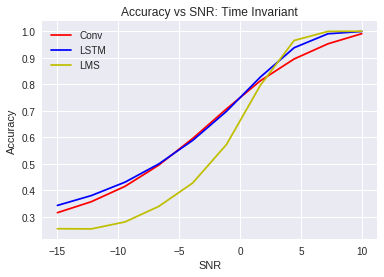

In [156]:
s_lstm = np.array(scores_lstm)
s_conv = np.array(scores_conv)
s_lms = 1-np.array([0,0.06,3.49,20.42,42.74,57.27,66.08,71.97,74.61,74.54])*1.0/100
plt.plot(snrs,s_conv[:,1],"r",label="Conv")
plt.plot(snrs,s_lstm[:,1],"b",label="LSTM")
plt.plot(snrs,s_lms,"y",label="LMS")
plt.legend()
plt.xlabel("SNR")
plt.ylabel("Accuracy")
plt.title("Accuracy vs SNR: Time Invariant")

from google.colab import files
plt.savefig('SNR_time_invariant.png')
files.download('SNR_time_invariant.png')

# Time-Varying Channel

In [0]:
def sim_channel_multi(m,sequenceLen,trials,Noise,SNRdB,h_list,channel_dur):
  """
  Simulates a channel
  Input:
    m - order of modulation
    sequenceLen - lenght of sequence
    trials - number trials
    Noise - Boolean, if noise should be added
    SNRdB - Ratio of signal to noise
    h_list- list of channel parameters for different channels
    channel_dur - duration of channel before switch
  """
  [x,y] = qammod2(m,sequenceLen,trials)
  distortedChannels = []
  for i in range(len(h_list)):
    distortedChannels.append(np.apply_along_axis(lambda q: np.convolve(q,h_list[i,:],mode="full"),axis = 1,arr = x))
   
  size = distortedChannels[0].shape[1]
  i = 0
  select = np.random.randint(len(h_list))
  selected_stream = distortedChannels[select]
  length = channel_dur
  if(i + length >= size):
    length = size - i
  xh = selected_stream[:,i:i+length,:]
  i = i + length
  while(i < size):
    select = np.random.randint(len(h_list))
    selected_stream = distortedChannels[select]
    length = channel_dur
    if(i + length >= size):
      length = size - i
    chunk = selected_stream[:,i:i+length,:]
    xh = np.concatenate((xh, chunk),axis = 1)
    i = i + length
    
  if(Noise):
    SNR = 10**(SNRdB/10)
    sym_noise_pow = np.var(xh)/SNR
    sym_noise_scale_fact = np.sqrt(sym_noise_pow/2)
    AWGN = sym_noise_scale_fact*np.random.normal(1, size=xh.shape) 
    xh = xh + AWGN
  return [xh ,y ]


def generateData_multi(m,sequenceLen,trials,Noise,SNRdB,h_list,channel_dur,padding=True,window=False,window_size = 10):
  """
  h_list = List of channel parameters 
  """
  data={}
  x_train,y_train = sim_channel_multi(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB,h_list=h_list,channel_dur=channel_dur)
  x_val,y_val= sim_channel_multi(m=m,sequenceLen=sequenceLen,trials=int(trials*0.5),Noise= Noise,SNRdB=SNRdB,h_list=h_list,channel_dur=channel_dur)
  x_test,y_test= sim_channel_multi(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB,h_list=h_list,channel_dur=channel_dur)
  
  print("x_train shape: ",x_train.shape) # data, expected seqlen+chanelLen-1
  print("y_train shape: ",y_train.shape) # labels
  
  #One hot encoding
  y_train = keras.utils.to_categorical(y_train , num_classes=m)
  y_val = keras.utils.to_categorical(y_val , num_classes=m)
  y_test = keras.utils.to_categorical(y_test , num_classes=m)
  print("y_train shape, one-hot: ",y_train.shape)

  #Padding 
  if(padding):
    y_train = np.pad(y_train,((0,0),(0,chanelLen-1),(0,0)),"constant")
    y_val = np.pad(y_val,((0,0),(0,chanelLen-1),(0,0)),"constant")
    y_test = np.pad(y_test,((0,0),(0,chanelLen-1),(0,0)),"constant")
    print("y_train shape, one-hot, padding: ",y_train.shape)
  
  #Windowing
  if(window):
    x_train = windowing(x_train,window_size)
    x_val = windowing(x_val,window_size)
    x_test = windowing(x_test,window_size)
    print("x_train shape, window: ",x_train.shape)
    
  default_data = {
    'x_train': x_train,
    'x_val': x_val,
    'x_test': x_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
  }
  return default_data
 
def windowing(x,window_size):
  """
  x - input data of dimension (trials,timestep,features)
  Will pad windows with zero 
  """
  trials, timestep, features = x.shape
  out = np.empty((trials,timestep,window_size*features))
  xpad = np.pad(x,((0,0),(0,window_size+1),(0,0)),"constant")
  for i in range(timestep):
    out[:,i] = np.reshape(xpad[:,i:i+window_size],(trials,window_size*features))
  return out

In [6]:
# Instantiating Data

m = 4         # order of modulation
trials = 10000 # number of trials 
Noise = True
SNRdB = 5
seqLen = 300
print(seqLen)
h_list = []
h_list.append(np.array([1,0.5,-0.3]))
h_list.append(np.array([1,-.5,-0.5]))
h_list.append(np.array([1,-0.25,-0.25]))
h_list = np.array(h_list)
chanelLen = len(h_list[0])
#chanelLen = 5
# h_list = np.random.rand(3,chanelLen)
# h_list[:,0] = 1
channel_dur = 75
print(h_list)

300
[[ 1.    0.5  -0.3 ]
 [ 1.   -0.5  -0.5 ]
 [ 1.   -0.25 -0.25]]


In [0]:
# QAM-4
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense,CuDNNLSTM, TimeDistributed,Bidirectional,BatchNormalization,Dropout,Conv1D, Flatten, Reshape,Softmax
from keras import optimizers
import keras

#LSTM no windwod
def LSTM_variant_no_window():
  data = generateData_multi(m,seqLen,trials,Noise,SNRdB,h_list,channel_dur,padding=True)
  modLSTM = Sequential()
  #modLSTM.add(Bidirectional(CuDNNLSTM(10,return_sequences=True),input_shape=(seqLen+chanelLen-1,2)))
  modLSTM.add(CuDNNLSTM(30,return_sequences=True,input_shape=(seqLen+chanelLen-1,2)))
  #modLSTM.add(TimeDistributed(Dense(30,activation="tanh")))
  modLSTM.add(TimeDistributed(BatchNormalization()))
  modLSTM.add(TimeDistributed(Dense(m,activation="softmax")))
  #return try_model_lstm(modLSTM, default_data_pad, epochs=10)
  
  #Training
  epochs = 20
  verbose = True
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy_with_masking', factor=0.2,
                              patience=3,verbose=verbose)

  opt = optimizers.Nadam()
  modLSTM.compile(optimizer= opt,
            loss=categorical_crossentropy_with_masking,
            metrics=[accuracy_with_masking])

  modLSTM.summary()  
  history = modLSTM.fit(data['x_train'], data['y_train'], 
            epochs=epochs, batch_size=int(0.1*trials), verbose=verbose, 
            validation_data=(data['x_val'], data['y_val']),
                     callbacks=[reduce_lr])  
  score = modLSTM.evaluate(data['x_test'], data['y_test'],batch_size = 1000)
  return history,score

#hist1, score1 = LSTM_variant_no_window() 


def LSTM_variant_with_window():
  window_size = chanelLen+2
  data = generateData_multi(m,seqLen,trials,Noise,SNRdB,h_list,channel_dur,padding=True,window=True,window_size=window_size)
  modLSTM = Sequential()
  modLSTM.add(CuDNNLSTM(40,return_sequences=True,input_shape=(seqLen+chanelLen-1,window_size*2),
                        recurrent_regularizer =regularizers.l1(0.0001),kernel_regularizer = regularizers.l2(0.001)))
#   modLSTM.add(CuDNNLSTM(50,return_sequences=True,input_shape=(seqLen+chanelLen-1,window_size*2),
#                         recurrent_regularizer =regularizers.l1(0.0001),kernel_regularizer = regularizers.l2(0.0001)))
  #modLSTM.add(TimeDistributed(BatchNormalization()))
  #modLSTM.add(TimeDistributed(Dense(30,activation="tanh")))
  #modLSTM.add(TimeDistributed(BatchNormalization()))
  #modLSTM.add(TimeDistributed(Dropout(0.2)))
  modLSTM.add(TimeDistributed(Dense(m,activation="softmax")))
  #return try_model_lstm(modLSTM, default_data_pad, epochs=10)

  #Training
  epochs = 20
  verbose = True
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy_with_masking', factor=0.2,
                              patience=3,verbose=verbose)
  
  opt = optimizers.Nadam()
  modLSTM.compile(optimizer= opt,
            loss=categorical_crossentropy_with_masking,
            metrics=[accuracy_with_masking])

  modLSTM.summary()  
  history = modLSTM.fit(data['x_train'], data['y_train'], 
            epochs=epochs, batch_size=int(0.1*trials), verbose=verbose, 
            validation_data=(data['x_val'], data['y_val']),
                     callbacks=[reduce_lr])  
  score = modLSTM.evaluate(data['x_test'], data['y_test'],batch_size = 1000)
  return history,score

#hist2, score2 = LSTM_variant_with_window()  

def ConvNet_variant():
  data = generateData_multi(m,seqLen,trials,Noise,SNRdB,h_list,channel_dur,padding=False)
  modCNN = Sequential()
  modCNN.add(Conv1D(10,kernel_size=(chanelLen), input_shape=(seqLen+chanelLen-1,2) ))
  modCNN.add(BatchNormalization())
  modCNN.add(Flatten())
  modCNN.add(Dense(seqLen*m,bias_regularizer=regularizers.l2(0.005)))
  modCNN.add(Reshape(target_shape = (seqLen,m)))
  modCNN.add(Softmax(axis=2))
  return try_model_conv(modCNN, data, epochs=20)

#hist3, score3 = ConvNet_variant()  
# print("Conv: ", score3)
# print("No Window: ", score1)
# print("With Window: ", score2)

In [7]:
m = 4         # order of modulation
trials = 15000   # number of trials 
Noise = True
seqLen = 300
print(seqLen)
h_list = []
h_list.append(np.array([1,0.5,-0.3]))
h_list.append(np.array([1,-.5,-0.5]))
h_list.append(np.array([1,-0.25,-0.25]))
# h_list.append(np.array([1,0.5,-0.3,.2,.1]))
# h_list.append(np.array([1,-.5,-0.5,.4,.1]))
# h_list.append(np.array([1,-0.25,-0.25,-.1, 0.7]))
h_list = np.array(h_list)
chanelLen = len(h_list[0])
channel_dur = 75
print("Channel: ",h_list)

snrs = np.linspace(10,-15,10)
histories_lstm2 = []
scores_lstm2 = []
histories_lstm2_W = []
scores_lstm2_W = []
histories_conv2 = []
scores_conv2 = []
for SNRdB in snrs:
  print("SNRdB: ",SNRdB)

  #LSTM no window
  hist,score = LSTM_variant_no_window()
  histories_lstm2.append(hist)
  scores_lstm2.append(score)
  print("Score: ",score)
  #LSTM with window
  hist,score = LSTM_variant_with_window()
  histories_lstm2_W.append(hist)
  scores_lstm2_W.append(score)
  print("Score: ",score)
  #CNN
  hist,score = ConvNet_variant()
  histories_conv2.append(hist)
  scores_conv2.append(score)
  print("Score: ",score)

300
Channel:  [[ 1.    0.5  -0.3 ]
 [ 1.   -0.5  -0.5 ]
 [ 1.   -0.25 -0.25]]
SNRdB:  10.0
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 302, 30)           4080      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 302, 30)           120       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 302, 4)            124       
Total params: 4,324
Trainable params: 4,264
Non-trainable params: 60
_________________________________________________________________
Train on 15000 samples, validate on 7500 samples
Epoch 1/20
15000/15000 [==============================] - 4s 246us/step - loss: 1.0302 - accuracy_with_masking:

15000/15000 [==============================] - 2s 116us/step - loss: 0.1759 - accuracy_with_masking: 0.9492 - val_loss: 0.2287 - val_accuracy_with_masking: 0.9162
Epoch 8/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1641 - accuracy_with_masking: 0.9516 - val_loss: 0.2158 - val_accuracy_with_masking: 0.9205
Epoch 9/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1543 - accuracy_with_masking: 0.9540 - val_loss: 0.2017 - val_accuracy_with_masking: 0.9264
Epoch 10/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.1462 - accuracy_with_masking: 0.9561 - val_loss: 0.1916 - val_accuracy_with_masking: 0.9302
Epoch 11/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1393 - accuracy_with_masking: 0.9579 - val_loss: 0.1819 - val_accuracy_with_masking: 0.9341
Epoch 12/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.1334 - accuracy_with_masking: 0.9594 - val_loss: 0.1744 

15000/15000 [==============================] - 2s 119us/step - loss: 0.1152 - accuracy_with_masking: 0.9627 - val_loss: 0.1523 - val_accuracy_with_masking: 0.9443
Epoch 18/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.1129 - accuracy_with_masking: 0.9630 - val_loss: 0.1506 - val_accuracy_with_masking: 0.9446
Epoch 19/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1109 - accuracy_with_masking: 0.9633 - val_loss: 0.1484 - val_accuracy_with_masking: 0.9451
Epoch 20/20
15000/15000 [==============================] - 1s 38us/step
Score:  [0.1916435847679774, 0.9250955581665039]
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
x_train shape, window:  (15000, 302, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 302, 

15000/15000 [==============================] - 2s 136us/step - loss: 0.8299 - accuracy_with_masking: 0.8312 - val_loss: 0.7802 - val_accuracy_with_masking: 0.7687
Epoch 5/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.6855 - accuracy_with_masking: 0.8681 - val_loss: 0.6646 - val_accuracy_with_masking: 0.8210
Epoch 6/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.5704 - accuracy_with_masking: 0.9003 - val_loss: 0.5707 - val_accuracy_with_masking: 0.8639
Epoch 7/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.4809 - accuracy_with_masking: 0.9233 - val_loss: 0.4966 - val_accuracy_with_masking: 0.8932
Epoch 8/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.4104 - accuracy_with_masking: 0.9400 - val_loss: 0.4375 - val_accuracy_with_masking: 0.9137
Epoch 9/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.3589 - accuracy_with_masking: 0.9509 - val_loss: 0.3902 - v

15000/15000 [==============================] - 2s 136us/step - loss: 0.2393 - accuracy_with_masking: 0.9694 - val_loss: 0.2697 - val_accuracy_with_masking: 0.9568
Epoch 15/20
15000/15000 [==============================] - 2s 138us/step - loss: 0.2271 - accuracy_with_masking: 0.9709 - val_loss: 0.2568 - val_accuracy_with_masking: 0.9591
Epoch 16/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.2166 - accuracy_with_masking: 0.9722 - val_loss: 0.2456 - val_accuracy_with_masking: 0.9611
Epoch 17/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.2073 - accuracy_with_masking: 0.9734 - val_loss: 0.2352 - val_accuracy_with_masking: 0.9631
Epoch 18/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.1990 - accuracy_with_masking: 0.9745 - val_loss: 0.2269 - val_accuracy_with_masking: 0.9645
Epoch 19/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.1927 - accuracy_with_masking: 0.9750 - val_loss: 0.219

15000/15000 [==============================] - 2s 143us/step - loss: 1.0137 - acc: 0.5925 - val_loss: 0.7439 - val_acc: 0.7194
Epoch 2/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.3419 - acc: 0.9389 - val_loss: 0.4880 - val_acc: 0.8162
Epoch 3/20
15000/15000 [==============================] - 1s 99us/step - loss: 0.1563 - acc: 0.9844 - val_loss: 0.4204 - val_acc: 0.8348
Epoch 4/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.0921 - acc: 0.9922 - val_loss: 0.4034 - val_acc: 0.8402
Epoch 5/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.0629 - acc: 0.9948 - val_loss: 0.4030 - val_acc: 0.8422
Epoch 6/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.0468 - acc: 0.9961 - val_loss: 0.4095 - val_acc: 0.8428
Epoch 7/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.0367 - acc: 0.9970 - val_loss: 0.4199 - val_acc: 0.8428
Epoch 8/20
15000/15000 [===========================

15000/15000 [==============================] - 1s 94us/step - loss: 0.0249 - acc: 0.9979 - val_loss: 0.4446 - val_acc: 0.8421
Epoch 10/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.0212 - acc: 0.9982 - val_loss: 0.4578 - val_acc: 0.8416
Epoch 11/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.0184 - acc: 0.9985 - val_loss: 0.4697 - val_acc: 0.8413
Epoch 12/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.0160 - acc: 0.9987 - val_loss: 0.4827 - val_acc: 0.8408
Epoch 13/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.0140 - acc: 0.9989 - val_loss: 0.4947 - val_acc: 0.8406
Epoch 14/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.0124 - acc: 0.9990 - val_loss: 0.5061 - val_acc: 0.8406
Epoch 15/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.0110 - acc: 0.9992 - val_loss: 0.5173 - val_acc: 0.8402
Epoch 16/20
15000/15000 [=====================

15000/15000 [==============================] - 1s 94us/step - loss: 0.0088 - acc: 0.9994 - val_loss: 0.5382 - val_acc: 0.8396
Epoch 18/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.0079 - acc: 0.9994 - val_loss: 0.5477 - val_acc: 0.8396
Epoch 19/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.0071 - acc: 0.9995 - val_loss: 0.5571 - val_acc: 0.8395
Epoch 20/20
15000/15000 [==============================] - 2s 114us/step
Test accuracy: [0.8874354990005493, 0.7673366653442383]
Score:  [0.8874354990005493, 0.7673366653442383]
SNRdB:  7.222222222222222
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 302, 30)           4080      
____________________________________________

15000/15000 [==============================] - 2s 117us/step - loss: 0.4030 - accuracy_with_masking: 0.9542 - val_loss: 0.4984 - val_accuracy_with_masking: 0.8210
Epoch 4/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.3120 - accuracy_with_masking: 0.9614 - val_loss: 0.4741 - val_accuracy_with_masking: 0.8216
Epoch 5/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.2581 - accuracy_with_masking: 0.9637 - val_loss: 0.4572 - val_accuracy_with_masking: 0.8236
Epoch 6/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.2222 - accuracy_with_masking: 0.9651 - val_loss: 0.4417 - val_accuracy_with_masking: 0.8279
Epoch 7/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1964 - accuracy_with_masking: 0.9664 - val_loss: 0.4317 - val_accuracy_with_masking: 0.8314
Epoch 8/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1769 - accuracy_with_masking: 0.9675 - val_loss: 0.4209 - v

15000/15000 [==============================] - 2s 119us/step - loss: 0.1237 - accuracy_with_masking: 0.9717 - val_loss: 0.3947 - val_accuracy_with_masking: 0.8489
Epoch 14/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1177 - accuracy_with_masking: 0.9722 - val_loss: 0.3968 - val_accuracy_with_masking: 0.8494
Epoch 15/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1125 - accuracy_with_masking: 0.9727 - val_loss: 0.3967 - val_accuracy_with_masking: 0.8504
Epoch 16/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1080 - accuracy_with_masking: 0.9731 - val_loss: 0.3990 - val_accuracy_with_masking: 0.8509
Epoch 17/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.1041 - accuracy_with_masking: 0.9734 - val_loss: 0.3989 - val_accuracy_with_masking: 0.8517
Epoch 18/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1007 - accuracy_with_masking: 0.9737 - val_loss: 0.401

15000/15000 [==============================] - 3s 185us/step - loss: 1.3218 - accuracy_with_masking: 0.4596 - val_loss: 1.2732 - val_accuracy_with_masking: 0.5563
Epoch 2/20
15000/15000 [==============================] - 2s 135us/step - loss: 1.1923 - accuracy_with_masking: 0.6131 - val_loss: 1.1227 - val_accuracy_with_masking: 0.6736
Epoch 3/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.0183 - accuracy_with_masking: 0.6932 - val_loss: 0.9443 - val_accuracy_with_masking: 0.7351
Epoch 4/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.8466 - accuracy_with_masking: 0.7625 - val_loss: 0.8063 - val_accuracy_with_masking: 0.7702
Epoch 5/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.7199 - accuracy_with_masking: 0.8080 - val_loss: 0.7025 - val_accuracy_with_masking: 0.8022
Epoch 6/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.6213 - accuracy_with_masking: 0.8457 - val_loss: 0.6202 - v

15000/15000 [==============================] - 2s 136us/step - loss: 0.3645 - accuracy_with_masking: 0.9225 - val_loss: 0.3851 - val_accuracy_with_masking: 0.9037
Epoch 12/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.3418 - accuracy_with_masking: 0.9264 - val_loss: 0.3658 - val_accuracy_with_masking: 0.9074
Epoch 13/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.3245 - accuracy_with_masking: 0.9286 - val_loss: 0.3517 - val_accuracy_with_masking: 0.9094
Epoch 14/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.3111 - accuracy_with_masking: 0.9301 - val_loss: 0.3386 - val_accuracy_with_masking: 0.9119
Epoch 15/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.2983 - accuracy_with_masking: 0.9323 - val_loss: 0.3269 - val_accuracy_with_masking: 0.9145
Epoch 16/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.2877 - accuracy_with_masking: 0.9341 - val_loss: 0.316

15000/15000 [==============================] - 1s 54us/step
Score:  [0.28935904105504356, 0.9230226635932922]
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_4 (Batch (None, 300, 10)           40        
_________________________________________________________________
flatten_2 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1200)              3601200   
_________________________________________________________________
reshape_2 (Reshape)          (None, 300, 4)            0         
______________________________________________________________

15000/15000 [==============================] - 1s 97us/step - loss: 0.2181 - acc: 0.9514 - val_loss: 1.2067 - val_acc: 0.5769
Epoch 4/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.1556 - acc: 0.9622 - val_loss: 1.3490 - val_acc: 0.5784
Epoch 5/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.1253 - acc: 0.9667 - val_loss: 1.4956 - val_acc: 0.5788
Epoch 6/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.1082 - acc: 0.9689 - val_loss: 1.6363 - val_acc: 0.5785
Epoch 7/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.0975 - acc: 0.9703 - val_loss: 1.7693 - val_acc: 0.5782
Epoch 8/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.0901 - acc: 0.9713 - val_loss: 1.9033 - val_acc: 0.5777
Epoch 9/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.0846 - acc: 0.9721 - val_loss: 2.0257 - val_acc: 0.5774
Epoch 10/20
15000/15000 [===========================

15000/15000 [==============================] - 1s 95us/step - loss: 0.0772 - acc: 0.9732 - val_loss: 2.2529 - val_acc: 0.5769
Epoch 12/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.0740 - acc: 0.9740 - val_loss: 2.3636 - val_acc: 0.5763
Epoch 13/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.0713 - acc: 0.9746 - val_loss: 2.4587 - val_acc: 0.5763
Epoch 14/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.0692 - acc: 0.9751 - val_loss: 2.5527 - val_acc: 0.5763
Epoch 15/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.0671 - acc: 0.9758 - val_loss: 2.6446 - val_acc: 0.5757
Epoch 16/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.0648 - acc: 0.9764 - val_loss: 2.7310 - val_acc: 0.5753
Epoch 17/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.0630 - acc: 0.9770 - val_loss: 2.8118 - val_acc: 0.5752
Epoch 18/20
15000/15000 [=====================

15000/15000 [==============================] - 1s 96us/step - loss: 0.0590 - acc: 0.9784 - val_loss: 2.9632 - val_acc: 0.5748
Epoch 20/20
15000/15000 [==============================] - 2s 113us/step
Test accuracy: [1.8114092968622844, 0.6997159985542297]
Score:  [1.8114092968622844, 0.6997159985542297]
SNRdB:  4.444444444444445
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_5 (CuDNNLSTM)     (None, 302, 30)           4080      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 302, 30)           120       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 302, 4)            124       
Total params: 4,324
Trainable params: 4,264
Non-trainabl

15000/15000 [==============================] - 2s 118us/step - loss: 0.4934 - accuracy_with_masking: 0.7989 - val_loss: 0.4233 - val_accuracy_with_masking: 0.8357
Epoch 6/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.4810 - accuracy_with_masking: 0.8037 - val_loss: 0.4158 - val_accuracy_with_masking: 0.8379
Epoch 7/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.4720 - accuracy_with_masking: 0.8072 - val_loss: 0.4112 - val_accuracy_with_masking: 0.8392
Epoch 8/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.4651 - accuracy_with_masking: 0.8100 - val_loss: 0.4088 - val_accuracy_with_masking: 0.8395
Epoch 9/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.4598 - accuracy_with_masking: 0.8122 - val_loss: 0.4076 - val_accuracy_with_masking: 0.8395
Epoch 10/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.4556 - accuracy_with_masking: 0.8139 - val_loss: 0.4074 - 

15000/15000 [==============================] - 2s 117us/step - loss: 0.4433 - accuracy_with_masking: 0.8194 - val_loss: 0.4033 - val_accuracy_with_masking: 0.8409
Epoch 16/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.4428 - accuracy_with_masking: 0.8196 - val_loss: 0.4002 - val_accuracy_with_masking: 0.8424
Epoch 17/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.4422 - accuracy_with_masking: 0.8199 - val_loss: 0.3974 - val_accuracy_with_masking: 0.8437
Epoch 18/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.4416 - accuracy_with_masking: 0.8201 - val_loss: 0.3957 - val_accuracy_with_masking: 0.8446
Epoch 19/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.4410 - accuracy_with_masking: 0.8205 - val_loss: 0.3941 - val_accuracy_with_masking: 0.8453
Epoch 20/20
15000/15000 [==============================] - 1s 38us/step
Score:  [0.4259129007657369, 0.8280351082483928]
x_train shape:  

15000/15000 [==============================] - 2s 137us/step - loss: 1.0296 - accuracy_with_masking: 0.7360 - val_loss: 0.9712 - val_accuracy_with_masking: 0.7008
Epoch 4/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.8810 - accuracy_with_masking: 0.7557 - val_loss: 0.8500 - val_accuracy_with_masking: 0.7263
Epoch 5/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.7656 - accuracy_with_masking: 0.7791 - val_loss: 0.7604 - val_accuracy_with_masking: 0.7513
Epoch 6/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.6776 - accuracy_with_masking: 0.8036 - val_loss: 0.6905 - val_accuracy_with_masking: 0.7756
Epoch 7/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.6095 - accuracy_with_masking: 0.8251 - val_loss: 0.6425 - val_accuracy_with_masking: 0.7908
Epoch 8/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.5615 - accuracy_with_masking: 0.8384 - val_loss: 0.6044 - v

15000/15000 [==============================] - 2s 137us/step - loss: 0.4617 - accuracy_with_masking: 0.8582 - val_loss: 0.5261 - val_accuracy_with_masking: 0.8236
Epoch 14/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.4520 - accuracy_with_masking: 0.8608 - val_loss: 0.5217 - val_accuracy_with_masking: 0.8243
Epoch 15/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.4447 - accuracy_with_masking: 0.8622 - val_loss: 0.5135 - val_accuracy_with_masking: 0.8271
Epoch 16/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.4354 - accuracy_with_masking: 0.8654 - val_loss: 0.5083 - val_accuracy_with_masking: 0.8287
Epoch 17/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.4298 - accuracy_with_masking: 0.8667 - val_loss: 0.5105 - val_accuracy_with_masking: 0.8272
Epoch 18/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.4243 - accuracy_with_masking: 0.8682 - val_loss: 0.496

15000/15000 [==============================] - 2s 165us/step - loss: 1.0554 - acc: 0.5611 - val_loss: 0.7586 - val_acc: 0.7071
Epoch 2/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.4477 - acc: 0.8700 - val_loss: 0.5641 - val_acc: 0.7935
Epoch 3/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.2751 - acc: 0.9227 - val_loss: 0.5370 - val_acc: 0.8083
Epoch 4/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.2119 - acc: 0.9350 - val_loss: 0.5507 - val_acc: 0.8126
Epoch 5/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.1831 - acc: 0.9393 - val_loss: 0.5780 - val_acc: 0.8139
Epoch 6/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.1678 - acc: 0.9414 - val_loss: 0.6094 - val_acc: 0.8143
Epoch 7/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.1580 - acc: 0.9433 - val_loss: 0.6435 - val_acc: 0.8140
Epoch 8/20
15000/15000 [===========================

15000/15000 [==============================] - 1s 97us/step - loss: 0.1468 - acc: 0.9458 - val_loss: 0.7052 - val_acc: 0.8137
Epoch 10/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.1426 - acc: 0.9469 - val_loss: 0.7321 - val_acc: 0.8136
Epoch 11/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.1392 - acc: 0.9482 - val_loss: 0.7578 - val_acc: 0.8136
Epoch 12/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.1359 - acc: 0.9494 - val_loss: 0.7790 - val_acc: 0.8135
Epoch 13/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.1329 - acc: 0.9505 - val_loss: 0.8024 - val_acc: 0.8132
Epoch 14/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.1299 - acc: 0.9516 - val_loss: 0.8202 - val_acc: 0.8136
Epoch 15/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.1272 - acc: 0.9526 - val_loss: 0.8406 - val_acc: 0.8130
Epoch 16/20
15000/15000 [=====================

15000/15000 [==============================] - 1s 95us/step - loss: 0.1216 - acc: 0.9548 - val_loss: 0.8671 - val_acc: 0.8134
Epoch 18/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.1190 - acc: 0.9559 - val_loss: 0.8849 - val_acc: 0.8131
Epoch 19/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.1169 - acc: 0.9566 - val_loss: 0.8958 - val_acc: 0.8130
Epoch 20/20
15000/15000 [==============================] - 2s 117us/step
Test accuracy: [0.9152881753603618, 0.7879482233683268]
Score:  [0.9152881753603618, 0.7879482233683268]
SNRdB:  1.6666666666666679
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_7 (CuDNNLSTM)     (None, 302, 30)           4080      
___________________________________________

15000/15000 [==============================] - 2s 118us/step - loss: 0.6064 - accuracy_with_masking: 0.7568 - val_loss: 0.6115 - val_accuracy_with_masking: 0.7483
Epoch 4/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.5777 - accuracy_with_masking: 0.7666 - val_loss: 0.6111 - val_accuracy_with_masking: 0.7476
Epoch 5/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.5661 - accuracy_with_masking: 0.7704 - val_loss: 0.6097 - val_accuracy_with_masking: 0.7489
Epoch 6/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.5601 - accuracy_with_masking: 0.7725 - val_loss: 0.6043 - val_accuracy_with_masking: 0.7516
Epoch 7/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.5563 - accuracy_with_masking: 0.7740 - val_loss: 0.5961 - val_accuracy_with_masking: 0.7555
Epoch 8/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.5537 - accuracy_with_masking: 0.7751 - val_loss: 0.5873 - v

15000/15000 [==============================] - 2s 118us/step - loss: 0.5470 - accuracy_with_masking: 0.7779 - val_loss: 0.5594 - val_accuracy_with_masking: 0.7724
Epoch 14/20
15000/15000 [==============================] - 2s 116us/step - loss: 0.5463 - accuracy_with_masking: 0.7782 - val_loss: 0.5577 - val_accuracy_with_masking: 0.7732
Epoch 15/20
15000/15000 [==============================] - 2s 116us/step - loss: 0.5458 - accuracy_with_masking: 0.7785 - val_loss: 0.5558 - val_accuracy_with_masking: 0.7740
Epoch 16/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.5453 - accuracy_with_masking: 0.7787 - val_loss: 0.5545 - val_accuracy_with_masking: 0.7746
Epoch 17/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.5449 - accuracy_with_masking: 0.7789 - val_loss: 0.5532 - val_accuracy_with_masking: 0.7752
Epoch 18/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.5446 - accuracy_with_masking: 0.7791 - val_loss: 0.552

15000/15000 [==============================] - 3s 212us/step - loss: 1.4347 - accuracy_with_masking: 0.3024 - val_loss: 1.3476 - val_accuracy_with_masking: 0.5135
Epoch 2/20
15000/15000 [==============================] - 2s 135us/step - loss: 1.2788 - accuracy_with_masking: 0.5527 - val_loss: 1.1883 - val_accuracy_with_masking: 0.6296
Epoch 3/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.1214 - accuracy_with_masking: 0.6414 - val_loss: 1.0295 - val_accuracy_with_masking: 0.7025
Epoch 4/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.9784 - accuracy_with_masking: 0.6930 - val_loss: 0.8908 - val_accuracy_with_masking: 0.7522
Epoch 5/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.8650 - accuracy_with_masking: 0.7246 - val_loss: 0.7823 - val_accuracy_with_masking: 0.7847
Epoch 6/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.7780 - accuracy_with_masking: 0.7514 - val_loss: 0.7020 - v

15000/15000 [==============================] - 2s 136us/step - loss: 0.6147 - accuracy_with_masking: 0.7907 - val_loss: 0.5494 - val_accuracy_with_masking: 0.8289
Epoch 12/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.6064 - accuracy_with_masking: 0.7915 - val_loss: 0.5423 - val_accuracy_with_masking: 0.8280
Epoch 13/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.5985 - accuracy_with_masking: 0.7930 - val_loss: 0.5339 - val_accuracy_with_masking: 0.8293
Epoch 14/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.5915 - accuracy_with_masking: 0.7946 - val_loss: 0.5271 - val_accuracy_with_masking: 0.8300
Epoch 15/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.5864 - accuracy_with_masking: 0.7955 - val_loss: 0.5217 - val_accuracy_with_masking: 0.8304
Epoch 16/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.5841 - accuracy_with_masking: 0.7952 - val_loss: 0.517

15000/15000 [==============================] - 1s 52us/step
Score:  [0.6155043244361877, 0.7765193303426107]
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_8 (Batch (None, 300, 10)           40        
_________________________________________________________________
flatten_4 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_4 (Reshape)          (None, 300, 4)            0         
_______________________________________________________________

15000/15000 [==============================] - 1s 95us/step - loss: 0.4785 - acc: 0.8146 - val_loss: 0.4981 - val_acc: 0.8015
Epoch 4/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.4441 - acc: 0.8248 - val_loss: 0.4848 - val_acc: 0.8065
Epoch 5/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.4305 - acc: 0.8301 - val_loss: 0.4809 - val_acc: 0.8095
Epoch 6/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.4212 - acc: 0.8342 - val_loss: 0.4789 - val_acc: 0.8114
Epoch 7/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.4136 - acc: 0.8380 - val_loss: 0.4767 - val_acc: 0.8129
Epoch 8/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.4061 - acc: 0.8414 - val_loss: 0.4732 - val_acc: 0.8152
Epoch 9/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.3992 - acc: 0.8439 - val_loss: 0.4697 - val_acc: 0.8167
Epoch 10/20
15000/15000 [===========================

15000/15000 [==============================] - 1s 95us/step - loss: 0.3871 - acc: 0.8488 - val_loss: 0.4651 - val_acc: 0.8184
Epoch 12/20
15000/15000 [==============================] - 1s 94us/step - loss: 0.3821 - acc: 0.8509 - val_loss: 0.4632 - val_acc: 0.8193
Epoch 13/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.3779 - acc: 0.8526 - val_loss: 0.4608 - val_acc: 0.8201
Epoch 14/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.3741 - acc: 0.8542 - val_loss: 0.4598 - val_acc: 0.8204
Epoch 15/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.3709 - acc: 0.8552 - val_loss: 0.4581 - val_acc: 0.8211
Epoch 16/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.3680 - acc: 0.8565 - val_loss: 0.4574 - val_acc: 0.8215
Epoch 17/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.3655 - acc: 0.8576 - val_loss: 0.4569 - val_acc: 0.8216
Epoch 18/20
15000/15000 [=====================

15000/15000 [==============================] - 1s 96us/step - loss: 0.3612 - acc: 0.8593 - val_loss: 0.4558 - val_acc: 0.8220
Epoch 20/20
15000/15000 [==============================] - 2s 117us/step
Test accuracy: [1.0796482714335123, 0.6607388889948527]
Score:  [1.0796482714335123, 0.6607388889948527]
SNRdB:  -1.1111111111111107
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_9 (CuDNNLSTM)     (None, 302, 30)           4080      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 302, 30)           120       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 302, 4)            124       
Total params: 4,324
Trainable params: 4,264
Non-traina

15000/15000 [==============================] - 2s 118us/step - loss: 0.7741 - accuracy_with_masking: 0.6796 - val_loss: 0.8007 - val_accuracy_with_masking: 0.6685
Epoch 6/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.7653 - accuracy_with_masking: 0.6838 - val_loss: 0.7915 - val_accuracy_with_masking: 0.6719
Epoch 7/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.7603 - accuracy_with_masking: 0.6862 - val_loss: 0.7848 - val_accuracy_with_masking: 0.6741
Epoch 8/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.7571 - accuracy_with_masking: 0.6877 - val_loss: 0.7790 - val_accuracy_with_masking: 0.6762
Epoch 9/20
15000/15000 [==============================] - 2s 116us/step - loss: 0.7548 - accuracy_with_masking: 0.6888 - val_loss: 0.7786 - val_accuracy_with_masking: 0.6760
Epoch 10/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.7532 - accuracy_with_masking: 0.6895 - val_loss: 0.7802 - 

15000/15000 [==============================] - 2s 119us/step - loss: 0.7506 - accuracy_with_masking: 0.6905 - val_loss: 0.7767 - val_accuracy_with_masking: 0.6766
Epoch 16/20
15000/15000 [==============================] - 2s 120us/step - loss: 0.7505 - accuracy_with_masking: 0.6905 - val_loss: 0.7762 - val_accuracy_with_masking: 0.6768
Epoch 17/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.7503 - accuracy_with_masking: 0.6906 - val_loss: 0.7760 - val_accuracy_with_masking: 0.6770
Epoch 18/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.7501 - accuracy_with_masking: 0.6907 - val_loss: 0.7759 - val_accuracy_with_masking: 0.6771
Epoch 19/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.7499 - accuracy_with_masking: 0.6907 - val_loss: 0.7759 - val_accuracy_with_masking: 0.6770
Epoch 20/20
15000/15000 [==============================] - 1s 39us/step
Score:  [0.9538516243298848, 0.608181111017863]
x_train shape:  (

15000/15000 [==============================] - 2s 136us/step - loss: 1.1024 - accuracy_with_masking: 0.6662 - val_loss: 1.0556 - val_accuracy_with_masking: 0.6308
Epoch 4/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.9657 - accuracy_with_masking: 0.7121 - val_loss: 0.9530 - val_accuracy_with_masking: 0.6605
Epoch 5/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.8527 - accuracy_with_masking: 0.7393 - val_loss: 0.8818 - val_accuracy_with_masking: 0.6795
Epoch 6/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.7706 - accuracy_with_masking: 0.7563 - val_loss: 0.8464 - val_accuracy_with_masking: 0.6852
Epoch 7/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.7178 - accuracy_with_masking: 0.7643 - val_loss: 0.8356 - val_accuracy_with_masking: 0.6846
Epoch 8/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.6890 - accuracy_with_masking: 0.7659 - val_loss: 0.8336 - v

15000/15000 [==============================] - 2s 135us/step - loss: 0.6551 - accuracy_with_masking: 0.7693 - val_loss: 0.8342 - val_accuracy_with_masking: 0.6845
Epoch 14/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.6547 - accuracy_with_masking: 0.7693 - val_loss: 0.8342 - val_accuracy_with_masking: 0.6845
Epoch 15/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.6543 - accuracy_with_masking: 0.7693 - val_loss: 0.8342 - val_accuracy_with_masking: 0.6846

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.6000001050997525e-05.
Epoch 16/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.6541 - accuracy_with_masking: 0.7694 - val_loss: 0.8342 - val_accuracy_with_masking: 0.6846
Epoch 17/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.6540 - accuracy_with_masking: 0.7694 - val_loss: 0.8342 - val_accuracy_with_masking: 0.6846
Epoch 18/20
15000/15000 [==============================

15000/15000 [==============================] - 3s 198us/step - loss: 1.1668 - acc: 0.4901 - val_loss: 1.0234 - val_acc: 0.5606
Epoch 2/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.7696 - acc: 0.6832 - val_loss: 0.9748 - val_acc: 0.6046
Epoch 3/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.7068 - acc: 0.7090 - val_loss: 0.9870 - val_acc: 0.6161
Epoch 4/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.6875 - acc: 0.7191 - val_loss: 0.9917 - val_acc: 0.6214
Epoch 5/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.6735 - acc: 0.7257 - val_loss: 0.9866 - val_acc: 0.6250
Epoch 6/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.6612 - acc: 0.7311 - val_loss: 0.9786 - val_acc: 0.6272
Epoch 7/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.6506 - acc: 0.7354 - val_loss: 0.9711 - val_acc: 0.6292
Epoch 8/20
15000/15000 [===========================

15000/15000 [==============================] - 1s 99us/step - loss: 0.6352 - acc: 0.7420 - val_loss: 0.9624 - val_acc: 0.6314
Epoch 10/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.6297 - acc: 0.7447 - val_loss: 0.9612 - val_acc: 0.6320
Epoch 11/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.6252 - acc: 0.7465 - val_loss: 0.9600 - val_acc: 0.6325
Epoch 12/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.6213 - acc: 0.7485 - val_loss: 0.9588 - val_acc: 0.6330
Epoch 13/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.6179 - acc: 0.7500 - val_loss: 0.9594 - val_acc: 0.6332
Epoch 14/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.6150 - acc: 0.7513 - val_loss: 0.9591 - val_acc: 0.6335
Epoch 15/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.6125 - acc: 0.7523 - val_loss: 0.9591 - val_acc: 0.6336
Epoch 16/20
15000/15000 [=====================

15000/15000 [==============================] - 1s 93us/step - loss: 0.6081 - acc: 0.7545 - val_loss: 0.9593 - val_acc: 0.6341
Epoch 18/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.6062 - acc: 0.7554 - val_loss: 0.9597 - val_acc: 0.6341
Epoch 19/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.6045 - acc: 0.7561 - val_loss: 0.9592 - val_acc: 0.6341
Epoch 20/20
15000/15000 [==============================] - 2s 118us/step
Test accuracy: [0.8607127987861634, 0.6670842220624288]
Score:  [0.8607127987861634, 0.6670842220624288]
SNRdB:  -3.8888888888888893
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_11 (CuDNNLSTM)    (None, 302, 30)           4080      
__________________________________________

15000/15000 [==============================] - 2s 120us/step - loss: 0.9960 - accuracy_with_masking: 0.5717 - val_loss: 0.9862 - val_accuracy_with_masking: 0.5700
Epoch 4/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.9811 - accuracy_with_masking: 0.5798 - val_loss: 0.9832 - val_accuracy_with_masking: 0.5737
Epoch 5/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.9757 - accuracy_with_masking: 0.5825 - val_loss: 0.9729 - val_accuracy_with_masking: 0.5800
Epoch 6/20
15000/15000 [==============================] - 2s 120us/step - loss: 0.9729 - accuracy_with_masking: 0.5838 - val_loss: 0.9621 - val_accuracy_with_masking: 0.5858
Epoch 7/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.9711 - accuracy_with_masking: 0.5846 - val_loss: 0.9500 - val_accuracy_with_masking: 0.5929
Epoch 8/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.9699 - accuracy_with_masking: 0.5852 - val_loss: 0.9396 - v

15000/15000 [==============================] - 2s 119us/step - loss: 0.9672 - accuracy_with_masking: 0.5863 - val_loss: 0.9288 - val_accuracy_with_masking: 0.6078
Epoch 14/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.9670 - accuracy_with_masking: 0.5865 - val_loss: 0.9277 - val_accuracy_with_masking: 0.6085
Epoch 15/20
15000/15000 [==============================] - 2s 120us/step - loss: 0.9665 - accuracy_with_masking: 0.5868 - val_loss: 0.9285 - val_accuracy_with_masking: 0.6080
Epoch 16/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.9662 - accuracy_with_masking: 0.5869 - val_loss: 0.9274 - val_accuracy_with_masking: 0.6085
Epoch 17/20
15000/15000 [==============================] - 2s 119us/step - loss: 0.9660 - accuracy_with_masking: 0.5870 - val_loss: 0.9282 - val_accuracy_with_masking: 0.6080

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 18/20
15000/15000 [==============================]

15000/15000 [==============================] - 4s 242us/step - loss: 1.3907 - accuracy_with_masking: 0.3684 - val_loss: 1.3234 - val_accuracy_with_masking: 0.4649
Epoch 2/20
15000/15000 [==============================] - 2s 135us/step - loss: 1.2676 - accuracy_with_masking: 0.4946 - val_loss: 1.2133 - val_accuracy_with_masking: 0.5291
Epoch 3/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.1634 - accuracy_with_masking: 0.5465 - val_loss: 1.1209 - val_accuracy_with_masking: 0.5650
Epoch 4/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.0859 - accuracy_with_masking: 0.5739 - val_loss: 1.0592 - val_accuracy_with_masking: 0.5826
Epoch 5/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.0393 - accuracy_with_masking: 0.5881 - val_loss: 1.0243 - val_accuracy_with_masking: 0.5930
Epoch 6/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.0173 - accuracy_with_masking: 0.5932 - val_loss: 1.0043 - v

15000/15000 [==============================] - 2s 136us/step - loss: 0.9865 - accuracy_with_masking: 0.5990 - val_loss: 0.9762 - val_accuracy_with_masking: 0.6037
Epoch 12/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.9836 - accuracy_with_masking: 0.5993 - val_loss: 0.9741 - val_accuracy_with_masking: 0.6037
Epoch 13/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.9819 - accuracy_with_masking: 0.5992 - val_loss: 0.9725 - val_accuracy_with_masking: 0.6033
Epoch 14/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.9802 - accuracy_with_masking: 0.5990 - val_loss: 0.9703 - val_accuracy_with_masking: 0.6035

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 15/20
15000/15000 [==============================] - 2s 135us/step - loss: 0.9775 - accuracy_with_masking: 0.5999 - val_loss: 0.9688 - val_accuracy_with_masking: 0.6041
Epoch 16/20
15000/15000 [==============================]

15000/15000 [==============================] - 1s 52us/step
Score:  [0.9931166370709738, 0.5900662144025167]
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_12 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_6 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_6 (Reshape)          (None, 300, 4)            0         
_______________________________________________________________

15000/15000 [==============================] - 1s 96us/step - loss: 0.9405 - acc: 0.6013 - val_loss: 1.0365 - val_acc: 0.5637
Epoch 4/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.9214 - acc: 0.6107 - val_loss: 1.0242 - val_acc: 0.5689
Epoch 5/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.9052 - acc: 0.6176 - val_loss: 1.0128 - val_acc: 0.5727
Epoch 6/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.8923 - acc: 0.6236 - val_loss: 1.0061 - val_acc: 0.5747
Epoch 7/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.8824 - acc: 0.6284 - val_loss: 1.0006 - val_acc: 0.5765
Epoch 8/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.8746 - acc: 0.6320 - val_loss: 0.9981 - val_acc: 0.5774
Epoch 9/20
15000/15000 [==============================] - 1s 99us/step - loss: 0.8688 - acc: 0.6350 - val_loss: 0.9963 - val_acc: 0.5779
Epoch 10/20
15000/15000 [===========================

15000/15000 [==============================] - 1s 96us/step - loss: 0.8601 - acc: 0.6392 - val_loss: 0.9941 - val_acc: 0.5791
Epoch 12/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.8568 - acc: 0.6408 - val_loss: 0.9933 - val_acc: 0.5794
Epoch 13/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.8540 - acc: 0.6425 - val_loss: 0.9928 - val_acc: 0.5797
Epoch 14/20
15000/15000 [==============================] - 1s 95us/step - loss: 0.8514 - acc: 0.6438 - val_loss: 0.9930 - val_acc: 0.5796
Epoch 15/20
15000/15000 [==============================] - 1s 97us/step - loss: 0.8493 - acc: 0.6447 - val_loss: 0.9922 - val_acc: 0.5800
Epoch 16/20
15000/15000 [==============================] - 1s 96us/step - loss: 0.8474 - acc: 0.6458 - val_loss: 0.9921 - val_acc: 0.5801
Epoch 17/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.8457 - acc: 0.6465 - val_loss: 0.9923 - val_acc: 0.5802
Epoch 18/20
15000/15000 [=====================

15000/15000 [==============================] - 1s 96us/step - loss: 0.8427 - acc: 0.6481 - val_loss: 0.9923 - val_acc: 0.5803
Epoch 20/20
15000/15000 [==============================] - 2s 118us/step
Test accuracy: [1.0378574694315592, 0.5580935565948486]
Score:  [1.0378574694315592, 0.5580935565948486]
SNRdB:  -6.666666666666664
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_13 (CuDNNLSTM)    (None, 302, 30)           4080      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 302, 30)           120       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 302, 4)            124       
Total params: 4,324
Trainable params: 4,264
Non-trainab

15000/15000 [==============================] - 2s 117us/step - loss: 1.1201 - accuracy_with_masking: 0.5045 - val_loss: 1.2172 - val_accuracy_with_masking: 0.4571
Epoch 6/20
15000/15000 [==============================] - 2s 120us/step - loss: 1.1187 - accuracy_with_masking: 0.5051 - val_loss: 1.2006 - val_accuracy_with_masking: 0.4628
Epoch 7/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.1179 - accuracy_with_masking: 0.5056 - val_loss: 1.1863 - val_accuracy_with_masking: 0.4686
Epoch 8/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.1174 - accuracy_with_masking: 0.5058 - val_loss: 1.1738 - val_accuracy_with_masking: 0.4742
Epoch 9/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.1170 - accuracy_with_masking: 0.5060 - val_loss: 1.1704 - val_accuracy_with_masking: 0.4756
Epoch 10/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.1167 - accuracy_with_masking: 0.5062 - val_loss: 1.1607 - 

15000/15000 [==============================] - 2s 118us/step - loss: 1.1159 - accuracy_with_masking: 0.5066 - val_loss: 1.1488 - val_accuracy_with_masking: 0.4871
Epoch 16/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.1157 - accuracy_with_masking: 0.5066 - val_loss: 1.1477 - val_accuracy_with_masking: 0.4878
Epoch 17/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.1156 - accuracy_with_masking: 0.5067 - val_loss: 1.1477 - val_accuracy_with_masking: 0.4879
Epoch 18/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.1156 - accuracy_with_masking: 0.5067 - val_loss: 1.1504 - val_accuracy_with_masking: 0.4863
Epoch 19/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.1156 - accuracy_with_masking: 0.5066 - val_loss: 1.1497 - val_accuracy_with_masking: 0.4868

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 20/20
15000/15000 [==============================]

Epoch 3/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.2385 - accuracy_with_masking: 0.4831 - val_loss: 1.2260 - val_accuracy_with_masking: 0.4798
Epoch 4/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.1903 - accuracy_with_masking: 0.5008 - val_loss: 1.2012 - val_accuracy_with_masking: 0.4864
Epoch 5/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.1626 - accuracy_with_masking: 0.5091 - val_loss: 1.1928 - val_accuracy_with_masking: 0.4889
Epoch 6/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.1487 - accuracy_with_masking: 0.5136 - val_loss: 1.1929 - val_accuracy_with_masking: 0.4874
Epoch 7/20
15000/15000 [==============================] - 2s 135us/step - loss: 1.1430 - accuracy_with_masking: 0.5144 - val_loss: 1.1911 - val_accuracy_with_masking: 0.4868
Epoch 8/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.1395 - accuracy_with_masking: 0.5144 - val_loss:

15000/15000 [==============================] - 2s 136us/step - loss: 1.1336 - accuracy_with_masking: 0.5155 - val_loss: 1.1837 - val_accuracy_with_masking: 0.4875
Epoch 14/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.1334 - accuracy_with_masking: 0.5155 - val_loss: 1.1835 - val_accuracy_with_masking: 0.4875

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.6000001050997525e-05.
Epoch 15/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.1333 - accuracy_with_masking: 0.5156 - val_loss: 1.1835 - val_accuracy_with_masking: 0.4875
Epoch 16/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.1333 - accuracy_with_masking: 0.5156 - val_loss: 1.1835 - val_accuracy_with_masking: 0.4875
Epoch 17/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.1333 - accuracy_with_masking: 0.5156 - val_loss: 1.1834 - val_accuracy_with_masking: 0.4876

Epoch 00017: ReduceLROnPlateau reducing learning rate 

15000/15000 [==============================] - 4s 237us/step - loss: 1.3633 - acc: 0.3824 - val_loss: 1.3256 - val_acc: 0.4080
Epoch 2/20
15000/15000 [==============================] - 1s 98us/step - loss: 1.1545 - acc: 0.4916 - val_loss: 1.3218 - val_acc: 0.4281
Epoch 3/20
15000/15000 [==============================] - 1s 96us/step - loss: 1.1274 - acc: 0.5079 - val_loss: 1.3103 - val_acc: 0.4341
Epoch 4/20
15000/15000 [==============================] - 1s 99us/step - loss: 1.1073 - acc: 0.5168 - val_loss: 1.2945 - val_acc: 0.4375
Epoch 5/20
15000/15000 [==============================] - 1s 93us/step - loss: 1.0899 - acc: 0.5239 - val_loss: 1.2809 - val_acc: 0.4397
Epoch 6/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.0759 - acc: 0.5302 - val_loss: 1.2723 - val_acc: 0.4411
Epoch 7/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.0654 - acc: 0.5356 - val_loss: 1.2668 - val_acc: 0.4421
Epoch 8/20
15000/15000 [===========================

15000/15000 [==============================] - 1s 96us/step - loss: 1.0514 - acc: 0.5433 - val_loss: 1.2630 - val_acc: 0.4429
Epoch 10/20
15000/15000 [==============================] - 1s 96us/step - loss: 1.0467 - acc: 0.5461 - val_loss: 1.2621 - val_acc: 0.4432
Epoch 11/20
15000/15000 [==============================] - 1s 96us/step - loss: 1.0430 - acc: 0.5479 - val_loss: 1.2620 - val_acc: 0.4434
Epoch 12/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.0400 - acc: 0.5496 - val_loss: 1.2613 - val_acc: 0.4433
Epoch 13/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.0374 - acc: 0.5513 - val_loss: 1.2616 - val_acc: 0.4435
Epoch 14/20
15000/15000 [==============================] - 1s 98us/step - loss: 1.0353 - acc: 0.5525 - val_loss: 1.2613 - val_acc: 0.4437
Epoch 15/20
15000/15000 [==============================] - 1s 98us/step - loss: 1.0333 - acc: 0.5535 - val_loss: 1.2613 - val_acc: 0.4439
Epoch 16/20
15000/15000 [=====================

15000/15000 [==============================] - 1s 97us/step - loss: 1.0303 - acc: 0.5554 - val_loss: 1.2616 - val_acc: 0.4440
Epoch 18/20
15000/15000 [==============================] - 1s 95us/step - loss: 1.0290 - acc: 0.5561 - val_loss: 1.2614 - val_acc: 0.4439
Epoch 19/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.0278 - acc: 0.5567 - val_loss: 1.2621 - val_acc: 0.4439
Epoch 20/20
15000/15000 [==============================] - 2s 121us/step
Test accuracy: [1.2206472225824991, 0.4562433325767517]
Score:  [1.2206472225824991, 0.4562433325767517]
SNRdB:  -9.444444444444443
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_15 (CuDNNLSTM)    (None, 302, 30)           4080      
___________________________________________

15000/15000 [==============================] - 2s 118us/step - loss: 1.2424 - accuracy_with_masking: 0.4296 - val_loss: 1.2910 - val_accuracy_with_masking: 0.4102
Epoch 4/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.2364 - accuracy_with_masking: 0.4319 - val_loss: 1.2791 - val_accuracy_with_masking: 0.4131
Epoch 5/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.2338 - accuracy_with_masking: 0.4332 - val_loss: 1.2670 - val_accuracy_with_masking: 0.4173
Epoch 6/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.2324 - accuracy_with_masking: 0.4340 - val_loss: 1.2585 - val_accuracy_with_masking: 0.4206
Epoch 7/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.2316 - accuracy_with_masking: 0.4346 - val_loss: 1.2536 - val_accuracy_with_masking: 0.4223
Epoch 8/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.2311 - accuracy_with_masking: 0.4349 - val_loss: 1.2504 - v

15000/15000 [==============================] - 2s 119us/step - loss: 1.2298 - accuracy_with_masking: 0.4356 - val_loss: 1.2443 - val_accuracy_with_masking: 0.4259
Epoch 14/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.2297 - accuracy_with_masking: 0.4356 - val_loss: 1.2440 - val_accuracy_with_masking: 0.4260
Epoch 15/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.2295 - accuracy_with_masking: 0.4357 - val_loss: 1.2435 - val_accuracy_with_masking: 0.4262
Epoch 16/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.2294 - accuracy_with_masking: 0.4358 - val_loss: 1.2432 - val_accuracy_with_masking: 0.4262
Epoch 17/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.2293 - accuracy_with_masking: 0.4358 - val_loss: 1.2430 - val_accuracy_with_masking: 0.4263
Epoch 18/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.2293 - accuracy_with_masking: 0.4358 - val_loss: 1.242

15000/15000 [==============================] - 4s 281us/step - loss: 1.4204 - accuracy_with_masking: 0.3196 - val_loss: 1.3722 - val_accuracy_with_masking: 0.3823
Epoch 2/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.3496 - accuracy_with_masking: 0.3999 - val_loss: 1.3178 - val_accuracy_with_masking: 0.4211
Epoch 3/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.3045 - accuracy_with_masking: 0.4259 - val_loss: 1.2811 - val_accuracy_with_masking: 0.4377
Epoch 4/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.2778 - accuracy_with_masking: 0.4371 - val_loss: 1.2608 - val_accuracy_with_masking: 0.4461
Epoch 5/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.2634 - accuracy_with_masking: 0.4425 - val_loss: 1.2503 - val_accuracy_with_masking: 0.4491
Epoch 6/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.2569 - accuracy_with_masking: 0.4437 - val_loss: 1.2449 - v

15000/15000 [==============================] - 2s 136us/step - loss: 1.2390 - accuracy_with_masking: 0.4457 - val_loss: 1.2287 - val_accuracy_with_masking: 0.4511
Epoch 12/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.2366 - accuracy_with_masking: 0.4460 - val_loss: 1.2267 - val_accuracy_with_masking: 0.4512
Epoch 13/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.2347 - accuracy_with_masking: 0.4459 - val_loss: 1.2253 - val_accuracy_with_masking: 0.4510
Epoch 14/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.2334 - accuracy_with_masking: 0.4458 - val_loss: 1.2241 - val_accuracy_with_masking: 0.4509

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 15/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.2317 - accuracy_with_masking: 0.4463 - val_loss: 1.2226 - val_accuracy_with_masking: 0.4516
Epoch 16/20
15000/15000 [==============================]

15000/15000 [==============================] - 1s 53us/step
Score:  [1.2163368066151936, 0.4556233366330465]
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_16 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_8 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_8 (Reshape)          (None, 300, 4)            0         
_______________________________________________________________

15000/15000 [==============================] - 1s 99us/step - loss: 1.2645 - acc: 0.4311 - val_loss: 1.3762 - val_acc: 0.3746
Epoch 4/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.2440 - acc: 0.4386 - val_loss: 1.3580 - val_acc: 0.3783
Epoch 5/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.2251 - acc: 0.4462 - val_loss: 1.3452 - val_acc: 0.3800
Epoch 6/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.2096 - acc: 0.4534 - val_loss: 1.3365 - val_acc: 0.3814
Epoch 7/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.1972 - acc: 0.4597 - val_loss: 1.3310 - val_acc: 0.3825
Epoch 8/20
15000/15000 [==============================] - 1s 96us/step - loss: 1.1879 - acc: 0.4653 - val_loss: 1.3277 - val_acc: 0.3832
Epoch 9/20
15000/15000 [==============================] - 1s 96us/step - loss: 1.1811 - acc: 0.4694 - val_loss: 1.3269 - val_acc: 0.3829
Epoch 10/20
15000/15000 [===========================

15000/15000 [==============================] - 1s 98us/step - loss: 1.1723 - acc: 0.4754 - val_loss: 1.3260 - val_acc: 0.3832
Epoch 12/20
15000/15000 [==============================] - 1s 95us/step - loss: 1.1692 - acc: 0.4772 - val_loss: 1.3252 - val_acc: 0.3837
Epoch 13/20
15000/15000 [==============================] - 1s 96us/step - loss: 1.1668 - acc: 0.4788 - val_loss: 1.3257 - val_acc: 0.3837
Epoch 14/20
15000/15000 [==============================] - 1s 98us/step - loss: 1.1648 - acc: 0.4800 - val_loss: 1.3255 - val_acc: 0.3836
Epoch 15/20
15000/15000 [==============================] - 1s 94us/step - loss: 1.1631 - acc: 0.4814 - val_loss: 1.3254 - val_acc: 0.3838
Epoch 16/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.1617 - acc: 0.4822 - val_loss: 1.3250 - val_acc: 0.3840
Epoch 17/20
15000/15000 [==============================] - 1s 99us/step - loss: 1.1604 - acc: 0.4832 - val_loss: 1.3263 - val_acc: 0.3835
Epoch 18/20
15000/15000 [=====================

15000/15000 [==============================] - 1s 98us/step - loss: 1.1583 - acc: 0.4845 - val_loss: 1.3257 - val_acc: 0.3838
Epoch 20/20
15000/15000 [==============================] - 2s 121us/step
Test accuracy: [1.3031127568562826, 0.39740977732340493]
Score:  [1.3031127568562826, 0.39740977732340493]
SNRdB:  -12.222222222222221
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_17 (CuDNNLSTM)    (None, 302, 30)           4080      
_________________________________________________________________
time_distributed_25 (TimeDis (None, 302, 30)           120       
_________________________________________________________________
time_distributed_26 (TimeDis (None, 302, 4)            124       
Total params: 4,324
Trainable params: 4,264
Non-trai

15000/15000 [==============================] - 2s 119us/step - loss: 1.3107 - accuracy_with_masking: 0.3788 - val_loss: 1.3235 - val_accuracy_with_masking: 0.3705
Epoch 6/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.3071 - accuracy_with_masking: 0.3806 - val_loss: 1.3172 - val_accuracy_with_masking: 0.3731
Epoch 7/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.3048 - accuracy_with_masking: 0.3818 - val_loss: 1.3138 - val_accuracy_with_masking: 0.3746
Epoch 8/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.3032 - accuracy_with_masking: 0.3826 - val_loss: 1.3116 - val_accuracy_with_masking: 0.3754
Epoch 9/20
15000/15000 [==============================] - 2s 117us/step - loss: 1.3019 - accuracy_with_masking: 0.3832 - val_loss: 1.3103 - val_accuracy_with_masking: 0.3757
Epoch 10/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.3009 - accuracy_with_masking: 0.3835 - val_loss: 1.3099 - 

15000/15000 [==============================] - 2s 119us/step - loss: 1.2987 - accuracy_with_masking: 0.3845 - val_loss: 1.3085 - val_accuracy_with_masking: 0.3752

Epoch 00015: ReduceLROnPlateau reducing learning rate to 8.000000379979611e-05.
Epoch 16/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.2986 - accuracy_with_masking: 0.3845 - val_loss: 1.3075 - val_accuracy_with_masking: 0.3763
Epoch 17/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.2986 - accuracy_with_masking: 0.3846 - val_loss: 1.3068 - val_accuracy_with_masking: 0.3771
Epoch 18/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.2986 - accuracy_with_masking: 0.3846 - val_loss: 1.3061 - val_accuracy_with_masking: 0.3776
Epoch 19/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.2986 - accuracy_with_masking: 0.3846 - val_loss: 1.3056 - val_accuracy_with_masking: 0.3781
Epoch 20/20
15000/15000 [==============================]

15000/15000 [==============================] - 2s 136us/step - loss: 1.3938 - accuracy_with_masking: 0.3470 - val_loss: 1.3737 - val_accuracy_with_masking: 0.3648
Epoch 3/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.3624 - accuracy_with_masking: 0.3724 - val_loss: 1.3508 - val_accuracy_with_masking: 0.3786
Epoch 4/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.3465 - accuracy_with_masking: 0.3793 - val_loss: 1.3404 - val_accuracy_with_masking: 0.3822
Epoch 5/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.3373 - accuracy_with_masking: 0.3827 - val_loss: 1.3313 - val_accuracy_with_masking: 0.3859
Epoch 6/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.3306 - accuracy_with_masking: 0.3848 - val_loss: 1.3260 - val_accuracy_with_masking: 0.3868
Epoch 7/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.3260 - accuracy_with_masking: 0.3854 - val_loss: 1.3226 - v

15000/15000 [==============================] - 2s 138us/step - loss: 1.3126 - accuracy_with_masking: 0.3864 - val_loss: 1.3113 - val_accuracy_with_masking: 0.3862

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 13/20
15000/15000 [==============================] - 2s 135us/step - loss: 1.3111 - accuracy_with_masking: 0.3869 - val_loss: 1.3092 - val_accuracy_with_masking: 0.3881
Epoch 14/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.3104 - accuracy_with_masking: 0.3872 - val_loss: 1.3089 - val_accuracy_with_masking: 0.3880
Epoch 15/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.3101 - accuracy_with_masking: 0.3872 - val_loss: 1.3086 - val_accuracy_with_masking: 0.3881
Epoch 16/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.3098 - accuracy_with_masking: 0.3873 - val_loss: 1.3082 - val_accuracy_with_masking: 0.3881

Epoch 00016: ReduceLROnPlateau reducing learning rate t

15000/15000 [==============================] - 1s 54us/step
Score:  [1.307089614868164, 0.38935978213946026]
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_18 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_9 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_9 (Reshape)          (None, 300, 4)            0         
_______________________________________________________________

15000/15000 [==============================] - 1s 98us/step - loss: 1.3518 - acc: 0.3751 - val_loss: 1.4292 - val_acc: 0.3316
Epoch 4/20
15000/15000 [==============================] - 1s 98us/step - loss: 1.3300 - acc: 0.3826 - val_loss: 1.4124 - val_acc: 0.3335
Epoch 5/20
15000/15000 [==============================] - 1s 98us/step - loss: 1.3108 - acc: 0.3901 - val_loss: 1.3988 - val_acc: 0.3355
Epoch 6/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.2938 - acc: 0.3977 - val_loss: 1.3884 - val_acc: 0.3375
Epoch 7/20
15000/15000 [==============================] - 1s 98us/step - loss: 1.2798 - acc: 0.4053 - val_loss: 1.3819 - val_acc: 0.3381
Epoch 8/20
15000/15000 [==============================] - 1s 99us/step - loss: 1.2692 - acc: 0.4117 - val_loss: 1.3778 - val_acc: 0.3385
Epoch 9/20
15000/15000 [==============================] - 1s 96us/step - loss: 1.2614 - acc: 0.4170 - val_loss: 1.3758 - val_acc: 0.3389
Epoch 10/20
15000/15000 [===========================

15000/15000 [==============================] - 1s 96us/step - loss: 1.2518 - acc: 0.4238 - val_loss: 1.3742 - val_acc: 0.3392
Epoch 12/20
15000/15000 [==============================] - 1s 96us/step - loss: 1.2488 - acc: 0.4263 - val_loss: 1.3742 - val_acc: 0.3393
Epoch 13/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.2465 - acc: 0.4280 - val_loss: 1.3743 - val_acc: 0.3394
Epoch 14/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.2445 - acc: 0.4294 - val_loss: 1.3744 - val_acc: 0.3393
Epoch 15/20
15000/15000 [==============================] - 1s 98us/step - loss: 1.2430 - acc: 0.4307 - val_loss: 1.3743 - val_acc: 0.3394
Epoch 16/20
15000/15000 [==============================] - 1s 100us/step - loss: 1.2417 - acc: 0.4317 - val_loss: 1.3745 - val_acc: 0.3392
Epoch 17/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.2406 - acc: 0.4325 - val_loss: 1.3745 - val_acc: 0.3395
Epoch 18/20
15000/15000 [====================

15000/15000 [==============================] - 1s 97us/step - loss: 1.2388 - acc: 0.4339 - val_loss: 1.3745 - val_acc: 0.3394
Epoch 20/20
15000/15000 [==============================] - 2s 121us/step
Test accuracy: [1.362413663927714, 0.3457806669076284]
Score:  [1.362413663927714, 0.3457806669076284]
SNRdB:  -15.0
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_19 (CuDNNLSTM)    (None, 302, 30)           4080      
_________________________________________________________________
time_distributed_28 (TimeDis (None, 302, 30)           120       
_________________________________________________________________
time_distributed_29 (TimeDis (None, 302, 4)            124       
Total params: 4,324
Trainable params: 4,264
Non-trainable params: 60
_

15000/15000 [==============================] - 2s 118us/step - loss: 1.3548 - accuracy_with_masking: 0.3307 - val_loss: 1.3841 - val_accuracy_with_masking: 0.3090
Epoch 6/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.3520 - accuracy_with_masking: 0.3327 - val_loss: 1.3763 - val_accuracy_with_masking: 0.3115
Epoch 7/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.3504 - accuracy_with_masking: 0.3336 - val_loss: 1.3705 - val_accuracy_with_masking: 0.3151
Epoch 8/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.3488 - accuracy_with_masking: 0.3351 - val_loss: 1.3658 - val_accuracy_with_masking: 0.3186
Epoch 9/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.3479 - accuracy_with_masking: 0.3359 - val_loss: 1.3631 - val_accuracy_with_masking: 0.3193
Epoch 10/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.3475 - accuracy_with_masking: 0.3362 - val_loss: 1.3606 - 

15000/15000 [==============================] - 2s 119us/step - loss: 1.3458 - accuracy_with_masking: 0.3376 - val_loss: 1.3517 - val_accuracy_with_masking: 0.3309
Epoch 16/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.3452 - accuracy_with_masking: 0.3383 - val_loss: 1.3502 - val_accuracy_with_masking: 0.3327
Epoch 17/20
15000/15000 [==============================] - 2s 117us/step - loss: 1.3450 - accuracy_with_masking: 0.3384 - val_loss: 1.3500 - val_accuracy_with_masking: 0.3321
Epoch 18/20
15000/15000 [==============================] - 2s 119us/step - loss: 1.3449 - accuracy_with_masking: 0.3384 - val_loss: 1.3489 - val_accuracy_with_masking: 0.3343
Epoch 19/20
15000/15000 [==============================] - 2s 118us/step - loss: 1.3451 - accuracy_with_masking: 0.3381 - val_loss: 1.3485 - val_accuracy_with_masking: 0.3338
Epoch 20/20
15000/15000 [==============================] - 1s 38us/step
Score:  [1.348013695081075, 0.33444888989130656]
x_train shape:  

15000/15000 [==============================] - 2s 137us/step - loss: 1.3882 - accuracy_with_masking: 0.3368 - val_loss: 1.3813 - val_accuracy_with_masking: 0.3406
Epoch 4/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.3765 - accuracy_with_masking: 0.3423 - val_loss: 1.3728 - val_accuracy_with_masking: 0.3431
Epoch 5/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.3690 - accuracy_with_masking: 0.3440 - val_loss: 1.3661 - val_accuracy_with_masking: 0.3445
Epoch 6/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.3630 - accuracy_with_masking: 0.3454 - val_loss: 1.3611 - val_accuracy_with_masking: 0.3453
Epoch 7/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.3592 - accuracy_with_masking: 0.3455 - val_loss: 1.3579 - val_accuracy_with_masking: 0.3453
Epoch 8/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.3555 - accuracy_with_masking: 0.3464 - val_loss: 1.3548 - v

15000/15000 [==============================] - 2s 136us/step - loss: 1.3464 - accuracy_with_masking: 0.3478 - val_loss: 1.3468 - val_accuracy_with_masking: 0.3471
Epoch 14/20
15000/15000 [==============================] - 2s 136us/step - loss: 1.3461 - accuracy_with_masking: 0.3472 - val_loss: 1.3473 - val_accuracy_with_masking: 0.3455
Epoch 15/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.3456 - accuracy_with_masking: 0.3470 - val_loss: 1.3455 - val_accuracy_with_masking: 0.3468

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 16/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.3440 - accuracy_with_masking: 0.3481 - val_loss: 1.3443 - val_accuracy_with_masking: 0.3477
Epoch 17/20
15000/15000 [==============================] - 2s 137us/step - loss: 1.3436 - accuracy_with_masking: 0.3482 - val_loss: 1.3442 - val_accuracy_with_masking: 0.3477
Epoch 18/20
15000/15000 [==============================]

15000/15000 [==============================] - 4s 276us/step - loss: 1.5334 - acc: 0.2864 - val_loss: 1.4512 - val_acc: 0.2999
Epoch 2/20
15000/15000 [==============================] - 1s 96us/step - loss: 1.4247 - acc: 0.3295 - val_loss: 1.4367 - val_acc: 0.3068
Epoch 3/20
15000/15000 [==============================] - 1s 96us/step - loss: 1.4029 - acc: 0.3368 - val_loss: 1.4205 - val_acc: 0.3090
Epoch 4/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.3815 - acc: 0.3435 - val_loss: 1.4062 - val_acc: 0.3121
Epoch 5/20
15000/15000 [==============================] - 1s 96us/step - loss: 1.3616 - acc: 0.3507 - val_loss: 1.3950 - val_acc: 0.3144
Epoch 6/20
15000/15000 [==============================] - 1s 98us/step - loss: 1.3436 - acc: 0.3589 - val_loss: 1.3869 - val_acc: 0.3160
Epoch 7/20
15000/15000 [==============================] - 1s 99us/step - loss: 1.3283 - acc: 0.3673 - val_loss: 1.3821 - val_acc: 0.3170
Epoch 8/20
13750/15000 [==========================>

15000/15000 [==============================] - 2s 101us/step - loss: 1.3164 - acc: 0.3750 - val_loss: 1.3790 - val_acc: 0.3173
Epoch 9/20
15000/15000 [==============================] - 1s 95us/step - loss: 1.3076 - acc: 0.3812 - val_loss: 1.3774 - val_acc: 0.3174
Epoch 10/20
15000/15000 [==============================] - 1s 98us/step - loss: 1.3016 - acc: 0.3859 - val_loss: 1.3764 - val_acc: 0.3176
Epoch 11/20
15000/15000 [==============================] - 1s 96us/step - loss: 1.2974 - acc: 0.3895 - val_loss: 1.3761 - val_acc: 0.3178
Epoch 12/20
15000/15000 [==============================] - 1s 98us/step - loss: 1.2943 - acc: 0.3921 - val_loss: 1.3761 - val_acc: 0.3177
Epoch 13/20
15000/15000 [==============================] - 1s 99us/step - loss: 1.2920 - acc: 0.3939 - val_loss: 1.3763 - val_acc: 0.3179
Epoch 14/20
15000/15000 [==============================] - 1s 97us/step - loss: 1.2902 - acc: 0.3956 - val_loss: 1.3761 - val_acc: 0.3178
Epoch 15/20
15000/15000 [=====================

15000/15000 [==============================] - 1s 100us/step - loss: 1.2876 - acc: 0.3978 - val_loss: 1.3760 - val_acc: 0.3179
Epoch 17/20
15000/15000 [==============================] - 1s 98us/step - loss: 1.2865 - acc: 0.3987 - val_loss: 1.3760 - val_acc: 0.3180
Epoch 18/20
15000/15000 [==============================] - 1s 99us/step - loss: 1.2857 - acc: 0.3995 - val_loss: 1.3761 - val_acc: 0.3180
Epoch 19/20
15000/15000 [==============================] - 1s 99us/step - loss: 1.2849 - acc: 0.4000 - val_loss: 1.3760 - val_acc: 0.3180
Epoch 20/20
15000/15000 [==============================] - 2s 122us/step
Test accuracy: [1.3724843554178874, 0.3215893332958221]
Score:  [1.3724843554178874, 0.3215893332958221]


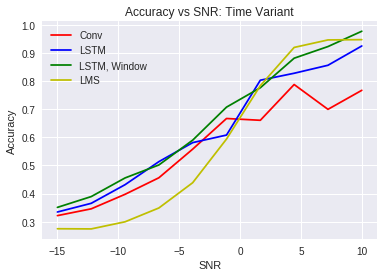

In [9]:
s_lstm2 = np.array(scores_lstm2)
s_lstm2_W = np.array(scores_lstm2_W)
s_conv2 = np.array(scores_conv2)
#s_lms2 = 1-np.array([2,2.47,5.82,21.18,41.54,56.99,66.24,71.6,73.42,74.5])*1.0/100
s_lms2 = 1-np.array([5.24,5.34,8.01,21.62,40.6,56.13,65.12,70.04,72.57,72.51])*1.0/100
plt.plot(snrs,s_conv2[:,1],"r",label="Conv")
plt.plot(snrs,s_lstm2[:,1],"b",label="LSTM")
plt.plot(snrs,s_lstm2_W[:,1],"g",label="LSTM, Window")
plt.plot(snrs,s_lms2,"y",label="LMS")
plt.legend()
plt.xlabel("SNR")
plt.ylabel("Accuracy")
plt.title("Accuracy vs SNR: Time Variant")

from google.colab import files
plt.savefig("SNR_time_variant.png")
files.download("SNR_time_variant.png")

##Base Case, No Noise Case

In [17]:
m = 4         # order of modulation
trials = 15000   # number of trials 
Noise = False
seqLen = 300
print(seqLen)
h_list = []
h_list.append(np.array([1,0.5,-0.3]))
h_list.append(np.array([1,-.5,-0.5]))
h_list.append(np.array([1,-0.25,-0.25]))
h_list = np.array(h_list)
chanelLen = len(h_list[0])
channel_dur = 75
print("Channel: ",h_list)


#LSTM no window
hist1_n ,score1_n = LSTM_variant_no_window()
#LSTM with window
hist2_n,score2_n = LSTM_variant_with_window()
#CNN
hist3_n,score3_n = ConvNet_variant()

print("LSTM No Window Score: ",score1_n)
print("LSTM with Window Score: ",score2_n)
print("Conv Score: ",score3_n)



300
Channel:  [[ 1.    0.5  -0.3 ]
 [ 1.   -0.5  -0.5 ]
 [ 1.   -0.25 -0.25]]
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_25 (CuDNNLSTM)    (None, 302, 30)           4080      
_________________________________________________________________
time_distributed_37 (TimeDis (None, 302, 30)           120       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 302, 4)            124       
Total params: 4,324
Trainable params: 4,264
Non-trainable params: 60
_________________________________________________________________
Train on 15000 samples, validate on 7500 samples
Epoch 1/20
15000/15000 [==============================] - 5s 357us/step - loss: 1.0215 - accuracy_with_masking: 0.5571 - val

15000/15000 [==============================] - 2s 121us/step - loss: 0.1587 - accuracy_with_masking: 0.9782 - val_loss: 0.2249 - val_accuracy_with_masking: 0.9409
Epoch 8/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.1308 - accuracy_with_masking: 0.9868 - val_loss: 0.2001 - val_accuracy_with_masking: 0.9622
Epoch 9/20
15000/15000 [==============================] - 2s 120us/step - loss: 0.1100 - accuracy_with_masking: 0.9921 - val_loss: 0.1771 - val_accuracy_with_masking: 0.9765
Epoch 10/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.0949 - accuracy_with_masking: 0.9943 - val_loss: 0.1575 - val_accuracy_with_masking: 0.9824
Epoch 11/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.0839 - accuracy_with_masking: 0.9956 - val_loss: 0.1427 - val_accuracy_with_masking: 0.9832
Epoch 12/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.0755 - accuracy_with_masking: 0.9962 - val_loss: 0.1313 

15000/15000 [==============================] - 2s 121us/step - loss: 0.0586 - accuracy_with_masking: 0.9974 - val_loss: 0.1113 - val_accuracy_with_masking: 0.9862
Epoch 18/20
15000/15000 [==============================] - 2s 120us/step - loss: 0.0577 - accuracy_with_masking: 0.9975 - val_loss: 0.1101 - val_accuracy_with_masking: 0.9871
Epoch 19/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.0569 - accuracy_with_masking: 0.9975 - val_loss: 0.1088 - val_accuracy_with_masking: 0.9879
Epoch 20/20
15000/15000 [==============================] - 1s 41us/step
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
x_train shape, window:  (15000, 302, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_26 (CuDNNLSTM)    (None, 302, 40)           8320      
________________________

15000/15000 [==============================] - 2s 137us/step - loss: 0.8128 - accuracy_with_masking: 0.8586 - val_loss: 0.8163 - val_accuracy_with_masking: 0.6661
Epoch 5/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.6504 - accuracy_with_masking: 0.9073 - val_loss: 0.6974 - val_accuracy_with_masking: 0.7462
Epoch 6/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.5142 - accuracy_with_masking: 0.9427 - val_loss: 0.6023 - val_accuracy_with_masking: 0.8289
Epoch 7/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.4150 - accuracy_with_masking: 0.9654 - val_loss: 0.5155 - val_accuracy_with_masking: 0.9127
Epoch 8/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.3390 - accuracy_with_masking: 0.9813 - val_loss: 0.4425 - val_accuracy_with_masking: 0.9585
Epoch 9/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.2835 - accuracy_with_masking: 0.9908 - val_loss: 0.3811 - v

15000/15000 [==============================] - 2s 136us/step - loss: 0.1618 - accuracy_with_masking: 0.9993 - val_loss: 0.2100 - val_accuracy_with_masking: 0.9994
Epoch 15/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.1510 - accuracy_with_masking: 0.9995 - val_loss: 0.1929 - val_accuracy_with_masking: 0.9995
Epoch 16/20
15000/15000 [==============================] - 2s 138us/step - loss: 0.1420 - accuracy_with_masking: 0.9995 - val_loss: 0.1790 - val_accuracy_with_masking: 0.9996
Epoch 17/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.1345 - accuracy_with_masking: 0.9996 - val_loss: 0.1673 - val_accuracy_with_masking: 0.9997
Epoch 18/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.1280 - accuracy_with_masking: 0.9997 - val_loss: 0.1574 - val_accuracy_with_masking: 0.9997
Epoch 19/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.1224 - accuracy_with_masking: 0.9997 - val_loss: 0.148

15000/15000 [==============================] - 5s 339us/step - loss: 0.9442 - acc: 0.6392 - val_loss: 0.7074 - val_acc: 0.7417
Epoch 2/20
15000/15000 [==============================] - 2s 100us/step - loss: 0.2399 - acc: 0.9847 - val_loss: 0.5791 - val_acc: 0.8057
Epoch 3/20
15000/15000 [==============================] - 2s 104us/step - loss: 0.0825 - acc: 0.9997 - val_loss: 0.6140 - val_acc: 0.8146
Epoch 4/20
15000/15000 [==============================] - 2s 104us/step - loss: 0.0409 - acc: 1.0000 - val_loss: 0.6678 - val_acc: 0.8164
Epoch 5/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.0247 - acc: 1.0000 - val_loss: 0.7193 - val_acc: 0.8166
Epoch 6/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.0167 - acc: 1.0000 - val_loss: 0.7643 - val_acc: 0.8165
Epoch 7/20
15000/15000 [==============================] - 2s 100us/step - loss: 0.0121 - acc: 1.0000 - val_loss: 0.8042 - val_acc: 0.8163
Epoch 8/20
15000/15000 [=====================

Epoch 9/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.8709 - val_acc: 0.8158
Epoch 10/20
15000/15000 [==============================] - 2s 104us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.8989 - val_acc: 0.8157
Epoch 11/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.9244 - val_acc: 0.8155
Epoch 12/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.9476 - val_acc: 0.8153
Epoch 13/20
15000/15000 [==============================] - 1s 100us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.9690 - val_acc: 0.8151
Epoch 14/20
15000/15000 [==============================] - 2s 103us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.9888 - val_acc: 0.8150
Epoch 15/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 1.0074 - val_acc: 0.8148
Epoch 16/20
12250/15000 [===

15000/15000 [==============================] - 2s 100us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 1.0241 - val_acc: 0.8148
Epoch 17/20
15000/15000 [==============================] - 2s 103us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.0406 - val_acc: 0.8146
Epoch 18/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.0560 - val_acc: 0.8144
Epoch 19/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 1.0702 - val_acc: 0.8143
Epoch 20/20
15000/15000 [==============================] - 2s 130us/step
Test accuracy: [0.06742531068722407, 0.9776008907953898]
LSTM No Window Score:  [0.051715163389841716, 0.996222448348999]
LSTM with Window Score:  [0.2623449683189392, 0.9389404416084289]
Conv Score:  [0.06742531068722407, 0.9776008907953898]
